In [51]:
import os
from dataclasses import dataclass, field
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import json
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, Nadam, SGD, RMSprop, Adagrad, Adadelta, Adamax
from bankroll_calc import BankrollCalculator
import sys
sys.path.append("/Users/atticussoane/Desktop/atticus_tools/")
from data_science import PrepTools, ModelSelectionTools
from sklearn.linear_model import LogisticRegression, SGDClassifier, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


In [486]:
pd.set_option("max.columns", 95)

elo_df = pd.read_csv("./moneyline_frame.csv.gz", compression = "gzip")
elo_df.head()

,date,home_OBPS,home_AVG_RUNS,home_AVG_H,home_BULLPEN_ERA,home_BULLPEN_WHIP,home_BULLPEN_AVG_INNINGS,home_total_OBPS,home_total_AVG_RUNS,home_total_AVG_H,home_total_BULLPEN_ERA,home_total_BULLPEN_WHIP,home_total_BULLPEN_AVG_INNINGS,road_OBPS,road_AVG_RUNS,road_AVG_H,road_BULLPEN_ERA,road_BULLPEN_WHIP,road_BULLPEN_AVG_INNINGS,road_total_OBPS,road_total_AVG_RUNS,road_total_AVG_H,road_total_BULLPEN_ERA,road_total_BULLPEN_WHIP,road_total_BULLPEN_AVG_INNINGS,home_career_ERA,home_career_WHIP,home_career_AVGIP,home_career_ERA_AH,home_career_WHIP_AH,home_career_AVGIP_AH,home_season_ERA,home_season_WHIP,home_season_AVGIP,home_season_ERA_AH,home_season_WHIP_AH,home_season_AVGIP_AH,road_career_ERA,road_career_WHIP,road_career_AVGIP,road_career_ERA_OR,road_career_WHIP_OR,road_career_AVGIP_OR,road_season_ERA,road_season_WHIP,road_season_AVGIP,road_season_ERA_OR,road_season_WHIP_OR,road_season_AVGIP_OR,elo1_pre,elo2_pre,elo_prob1,rating1_pre,rating2_pre,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,score1,score2,pitching_park_factor,batting_park_factor,TMAX,PRCP,SNOW,SNWD,attendance,current_streak_hm_tm,current_streak_hm_at_hm,home_record_hm,run_differential_hm,avg_margin_hm,distance_traveled,current_streak_rd_tm,current_streak_rd_tm_on_rd,rd_record_rd,run_differential_rd,avg_margin_rd,home_opening,home_closing,total_open,total_openJ,total_close,total_closeJ,road_opening,road_closing,home_win,year,home_payout,road_payout
0,2010-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.798175,1.219565,6.213511,3.872963,1.209871,6.163983,0.0,0.0,0.0,0.0,0.0,0.0,3.644033,1.232144,6.560382,3.686090,1.217175,6.583931,0.0,0.0,0.0,0.0,0.0,0.0,1537.262,1568.875,0.489046,1536.601,1562.673,57.031,61.828,27.349300,46.703900,0.471714,9.0,7.0,105.0,106.0,244.000000,0.0,0.0,0.0,37440.0,0.0,0.0,0.0,0.0,0.0,289.0,0.0,0.0,0.0,0.0,0.0,-114.0,-117.0,9.0,-104.0,9.0,-115.0,104.0,107.0,1,2010,1.854701,2.070000
1,2010-04-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.026421,1.309086,6.071488,3.440926,1.212388,6.378993,0.0,0.0,0.0,0.0,0.0,0.0,3.494632,1.286260,6.438445,3.265724,1.290606,6.430427,0.0,0.0,0.0,0.0,0.0,0.0,1519.750,1505.513,0.554806,1518.661,1505.908,47.147,52.834,8.713313,11.540052,0.552381,16.0,5.0,97.0,98.0,300.000000,0.0,0.0,0.0,53081.0,0.0,0.0,0.0,0.0,0.0,958.0,0.0,0.0,0.0,0.0,0.0,-130.0,-125.0,8.5,-110.0,8.5,-120.0,115.0,110.0,1,2010,1.800000,2.100000
2,2010-04-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.592236,1.303634,6.091569,2.943396,1.169811,6.115385,0.0,0.0,0.0,0.0,0.0,0.0,3.811220,1.317898,6.088554,4.211663,1.387889,5.814419,0.0,0.0,0.0,0.0,0.0,0.0,1495.496,1516.869,0.503780,1496.540,1517.409,53.119,59.030,28.872100,29.196400,0.505293,3.0,5.0,100.0,100.0,255.038764,0.0,0.0,0.0,45808.0,0.0,0.0,0.0,0.0,0.0,1464.0,0.0,0.0,0.0,0.0,0.0,-125.0,-105.0,7.5,-115.0,7.5,-125.0,110.0,-105.0,0,2010,1.952381,1.952381
3,2010-04-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.725154,1.249163,6.105909,3.270368,1.165200,6.282830,0.0,0.0,0.0,0.0,0.0,0.0,4.285186,1.263521,5.953945,4.389571,1.337423,5.927273,0.0,0.0,0.0,0.0,0.0,0.0,1544.703,1521.978,0.566840,1543.114,1520.771,54.034,55.637,16.337200,26.827600,0.550540,6.0,3.0,96.0,96.0,167.000000,30.0,0.0,0.0,43504.0,0.0,0.0,0.0,0.0,0.0,2441.0,0.0,0.0,0.0,0.0,0.0,-135.0,-128.0,8.5,100.0,8.5,110.0,120.0,113.0,1,2010,1.781250,2.130000
4,2010-04-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.398961,1.322743,5.845536,4.441558,1.259740,5.923077,0.0,0.0,0.0,0.0,0.0,0.0,3.846260,1.246243,5.667031,3.933896,1.293336,5.567000,0.0,0.0,0.0,0.0,0.0,0.0,1515.833,1514.391,0.536549,1517.118,1515.563,53.062,54.135,11.637200,17.140900,0.528309,5.0,4.0,108.0,109.0,283.000000,0.0,0.0,0.0,50299.0,0.0,0.0,0.0,0.0,0.0,1959.0,0.0,0.0,0.0,0.0,0.0,-135.0,-1

In [2]:
df = pd.read_csv("./adv_metrics/all_metrics_with_odds.csv.gz", compression = "gzip", low_memory = False)

pd.set_option("max.columns", 200)

df.head()

,date,home_close_TJ,home_close_ou,home_closing,home_open_TJ,home_open_ou,home_opening,home_runline,home_runline_juice,is_doubleheader,road_close_TJ,road_close_ou,road_closing,road_open_TJ,road_open_ou,road_opening,road_runline,road_runline_juice,is_tripleheader,season,home_team,road_team,home_starter,road_starter,home_wOBA,home_wRAA,home_wRC,home_OPS,home_relief_wOBA,home_relief_wRAA,home_relief_wRC,home_relief_FIP,home_relief_WHIP,home_relief_ERA,home_relief_K_BB,home_relief_K_9,home_starter_career_wOBA,home_starter_career_wRAA,home_starter_career_wRC,home_starter_career_FIP,home_starter_career_WHIP,home_starter_career_ERA,home_starter_careerK/BB,home_starter_careerK/9,home_starter_career_AVGIP,home_starter_season_wOBA,home_starter_season_wRAA,home_starter_season_wRC,home_starter_season_FIP,home_starter_season_WHIP,home_starter_season_ERA,home_starter_seasonK/BB,home_starter_seasonK/9,home_starter_seasonAVG_IP,road_wOBA,road_wRAA,road_wRC,road_OPS,road_relief_wOBA,road_relief_wRAA,road_relief_wRC,road_relief_FIP,road_relief_WHIP,road_relief_ERA,road_relief_K_BB,road_relief_K_9,road_starter_career_wOBA,road_starter_career_wRAA,road_starter_career_wRC,road_starter_career_FIP,road_starter_career_WHIP,road_starter_career_ERA,road_starter_careerK/BB,road_starter_careerK/9,road_starter_career_AVGIP,road_starter_season_wOBA,road_starter_season_wRAA,road_starter_season_wRC,road_starter_season_FIP,road_starter_season_WHIP,road_starter_season_ERA,road_starter_seasonK/BB,road_starter_seasonK/9,road_starter_seasonAVG_IP,home_payout,road_payout,elo1_pre,elo2_pre,rating1_pre,rating2_pre,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,score1,score2,home_win,home_favorite
0,2010-04-04,-115,9,-117.0,-104,9.0,-114,NaN,NaN,0,-105,9,107.0,-116,9.0,104,NaN,NaN,0.0,2010.0,BOS,NYY,beckj002,sabac001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.854701,2.070000,1537.262,1568.875,1536.601,1562.673,57.031,61.828,27.349300,46.7039,0.471714,9.0,7.0,1,1
1,2010-04-05,105,7.5,175.0,-120,7.5,175,NaN,NaN,0,-125,7.5,-200.0,100,7.5,-200,NaN,NaN,0.0,2010.0,WSN,PHI,lannj001,hallr001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.750000,1.500000,1460.859,1541.211,1460.662,1537.875,49.834,62.166,8.394200,49.4957,0.366599,1.0,11.0,0,0
2,2010-04-05,-105,7,137.0,-105,7.0,110,NaN,NaN,0,-115,7,-152.0,-115,7.0,-125,NaN,NaN,0.0,2010.0,OAK,SEA,sheeb001,hernf002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.370000,1.657895,1509.222,1501.778,1513.910,1500.945,56.701,60.524,7.593298,46.4172,0.501246,3.0,5.0,0,0
3,2010-04-05,110,8.5,-128.0,100,8.5,-135,NaN,NaN,0,-130,8.5,113.0,-120,8.5,120,NaN,NaN,0.0,2010.0,ANA,MIN,weavj003,bakes002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.781250,2.130000,1544.703,1521.978,1543.114,1520.771,54.034,55.637,16.337200,26.8276,0.550540,6.0,3.0,1,1
4,2010-04-05,-115,7,-122.0,-115,7.0,-115,NaN,NaN,0,-105,7,112.0,-105,7.0,105,NaN,NaN,0.0,2010.0,KCR,DET,greiz001,verlj001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.819672,2.120000,1476.779,1502.086,1478.280,1500.407,63

In [48]:
example_df = df[["rating_prob1", "home_win", "season"]]

In [50]:
e2019 = example_df[example_df.season == 2019]

In [52]:
preds = e2019.rating_prob1.values

In [54]:
preds = [1 if i > 0.5 else 0 for i in preds]

In [56]:
accuracy_score(e2019.home_win, preds)

0.5981543624161074

In [3]:
try:
    
    df.home_opening = df.home_opening.astype("float32")
    
except Exception as e:
    
    print(e)

could not convert string to float: 'NL'


In [4]:
probs = df[df.home_opening == "NL"].index

for k in probs:
    
    df.at[k, "home_opening"] = df.iloc[k]["home_closing"]
    
probs = df[df.road_opening == "NL"].index

for k in probs:
    
    df.at[k, "road_opening"] = df.iloc[k]["road_closing"]
    
df.home_opening = df.home_opening.astype("float32")

df.road_opening = df.road_opening.astype("float32")

In [5]:
def money_movement(df):
    
    direction = []
    
    quantity = []
    
    for k in range(len(df)):
        
        if df.iloc[k]["home_opening"] < 0:
            
            if df.iloc[k]["home_closing"] < df.iloc[k]["home_opening"]:
                
                direction.append(1)
                
                quantity.append(df.iloc[k]["home_closing"] - df.iloc[k]["home_opening"])
                
            elif df.iloc[k]["home_closing"] > df.iloc[k]["home_opening"]:
                
                direction.append(-1)
                
                if df.iloc[k]["home_closing"] > 0:
                    
                    quantity.append((-1*df.iloc[k]["home_opening"] - 100) +\
                                   (df.iloc[k]["home_closing"] - 100))
                else:
                    
                    quantity.append(df.iloc[k]["home_closing"] - df.iloc[k]["home_opening"])
                
            else:
                
                direction.append(0)
                
                quantity.append(0)
                
        else:
            
            if df.iloc[k]["home_closing"] < df.iloc[k]["home_opening"]:
                
                direction.append(1)
                
                if df.iloc[k]["home_closing"] < 0:
                    
                    quantity.append((df.iloc[k]["home_closing"] + 100) - (df.iloc[k]["home_opening"] - 100))
                    
                else:
                    
                    quantity.append(df.iloc[k]["home_closing"] - df.iloc[k]["home_opening"])
                    
            elif df.iloc[k]["home_closing"] > df.iloc[k]["home_opening"]:
                
                direction.append(-1)
                
                quantity.append(df.iloc[k]["home_closing"] - df.iloc[k]["home_opening"])
                
            else:
                
                direction.append(0)
                
                quantity.append(0)
                
    return(direction, quantity)

In [6]:
direction, scalar = money_movement(df)

direction_train = pd.Series(direction).rename("line_movement")

scalar_train = pd.Series(scalar).rename("money_scalar")

In [7]:
df = pd.concat([df, direction_train, scalar_train], axis = 1)

In [8]:
df.to_csv("./adv_metrics/all_metrics_with_odds.csv.gz", compression = "gzip")

In [34]:
home_dogs = df[(df.home_closing > 0)].reset_index(drop = True)

home_dogs.home_payout = home_dogs.home_payout - 1

home_dogs.road_payout = home_dogs.road_payout - 1

In [36]:
prep = PrepTools(home_dogs.drop(columns = ["home_win", "score1", "score2"]),
                home_dogs.home_win)

In [39]:
target_corr = prep.get_correlation_with_target(target_name = "home_win")

In [42]:
target_corr[:30]

home_closing              home_win    0.104173
home_payout               home_win    0.104173
road_payout               home_win    0.103085
road_closing              home_win    0.099835
home_runline_juice        home_win    0.087487
rating_prob1              home_win    0.082443
road_runline_juice        home_win    0.069157
road_opening              home_win    0.064173
home_opening              home_win    0.056848
rating2_pre               home_win    0.049738
rating1_pre               home_win    0.045010
road_starter_season_wRAA  home_win    0.044259
elo2_pre                  home_win    0.044122
road_starter_career_wRAA  home_win    0.041475
elo1_pre                  home_win    0.041334
road_starter_season_wRC   home_win    0.039691
home_relief_ERA           home_win    0.034549
road_starter_season_FIP   home_win    0.033169
road_starter_career_wRC   home_win    0.032639
road_starter_season_wOBA  home_win    0.030797
money_scalar              home_win    0.030367
home_runline 

In [44]:
feature_corr = prep.feature_frame_correlation(tol = 0.75)

In [47]:
feature_corr[:40]

home_runline               road_runline                 1.000000
home_open_ou               road_open_ou                 1.000000
home_closing               home_payout                  1.000000
road_wOBA                  road_OPS                     0.990188
home_wOBA                  home_OPS                     0.989945
home_starter_careerK/9     home_starter_seasonK/9       0.981321
home_starter_career_AVGIP  home_starter_seasonAVG_IP    0.980951
home_starter_careerK/BB    home_starter_seasonK/BB      0.979786
road_starter_career_wRAA   road_starter_season_wRAA     0.979146
elo1_pre                   rating1_pre                  0.978324
home_closing               road_closing                 0.977265
road_closing               home_payout                  0.977265
home_starter_career_wRAA   home_starter_season_wRAA     0.977259
home_starter_career_ERA    home_starter_season_ERA      0.976975
road_starter_careerK/9     road_starter_seasonK/9       0.976445
road_starter_career_ERA  

# BASELINE ELO PROB PROFIT

To get an idea of model expectations and the difficulty of the problem at hand, I have calculated and plotted the success of both random choice and the popular FiveThirtyEight MLB rating system... FiveThirtyEight produces a win probability for each team for each game, and using this probability I have calculated the total betting profit from the FiveThirtyEight system.

In [488]:
random_choice = [np.random.binomial(1, 0.5) for _ in range(2424)]

elo_2019 = elo_df[elo_df.year == 2019][["rating_prob1", "home_closing", "date", "road_closing", "home_win"]]

elo_preds = elo_2019.rating_prob1.values
y = elo_2019.home_win.values
dates = elo_2019.date.reset_index(drop = True)

home_c = elo_2019.home_closing.values
road_c = elo_2019.road_closing.values

len(elo_preds), len(y), len(dates), len(home_c), len(road_c)

(2424, 2424, 2424, 2424, 2424)

In [4]:
if not os.path.exists("./neural_net/bankroll_images/"):
    os.makedirs("./neural_net/bankroll_images/")

Graphic written to file ./neural_net/bankroll_images/random_base.png


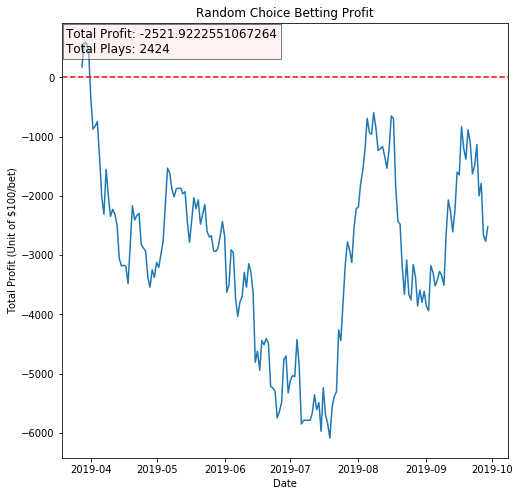

In [34]:
bc = BankrollCalculator(random_choice, y, dates,
                       home_c, road_c, fig_title = "Random Choice Betting Profit",
                       save_fig = True, img_dest = "./neural_net/bankroll_images/random_base.png")

bc.plot_profit()

Graphic written to file ./neural_net/bankroll_images/elo_base.png


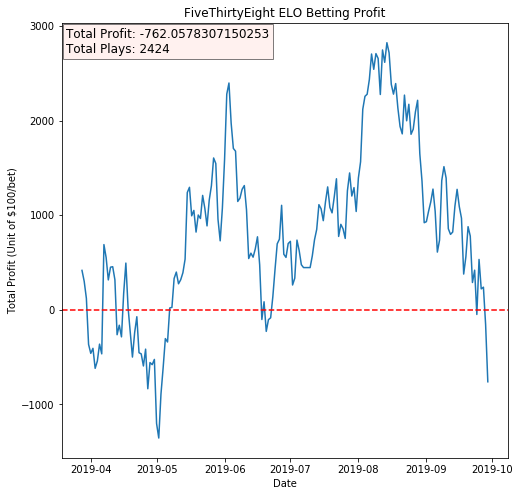

In [7]:
bc = BankrollCalculator(elo_preds, y, dates, 
                        home_c, road_c, fig_title = "FiveThirtyEight ELO Betting Profit",
                       save_fig = True, img_dest = "./neural_net/bankroll_images/elo_base.png")

bc.plot_profit()

Graphic written to file ./neural_net/bankroll_images/elo_home_dogs.png


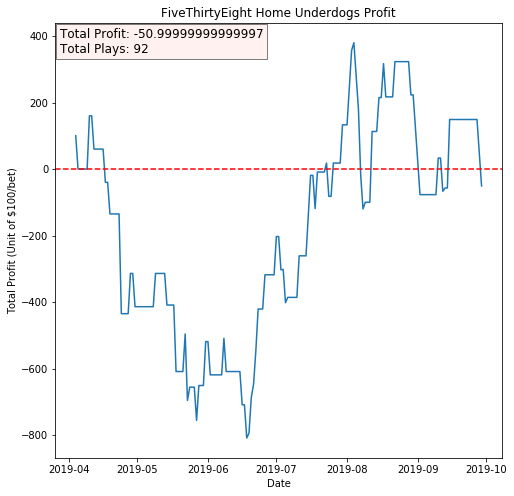

In [495]:
elo_home_dogs = elo_2019[(elo_2019.rating_prob1 > 0.5) & (elo_2019.home_closing > 0)].reset_index(drop = True)

bc = BankrollCalculator(elo_home_dogs.rating_prob1, elo_home_dogs.home_win, elo_home_dogs.date, 
                        elo_home_dogs.home_closing, elo_home_dogs.road_closing, 
                        fig_title = "FiveThirtyEight Home Underdogs Profit",
                       save_fig = True, img_dest = "./neural_net/bankroll_images/elo_home_dogs.png")

bc.plot_profit()

Graphic written to file ./neural_net/bankroll_images/elo_road_dogs.png


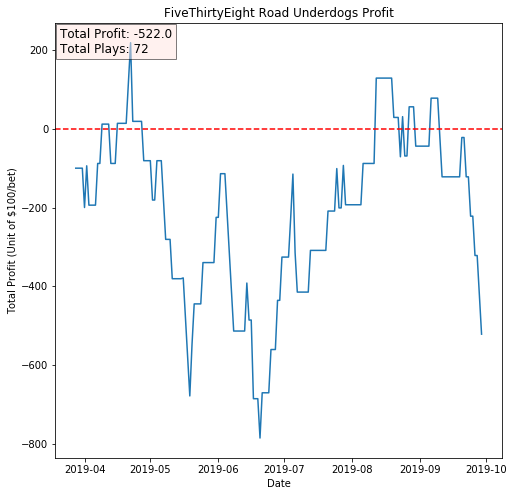

In [496]:
elo_road_dogs = elo_2019[(elo_2019.rating_prob1 < 0.5) & (elo_2019.road_closing > 0)].reset_index(drop = True)

bc = BankrollCalculator(elo_road_dogs.rating_prob1, elo_road_dogs.home_win, elo_road_dogs.date, 
                        elo_road_dogs.home_closing, elo_road_dogs.road_closing, 
                        fig_title = "FiveThirtyEight Road Underdogs Profit",
                       save_fig = True, img_dest = "./neural_net/bankroll_images/elo_road_dogs.png")

bc.plot_profit()

This gives us a scope for how challenging the problem is. 

In [35]:
with open("./selected_features.json", "r+") as f:
    set1 = json.load(f)
with open("./neural_net/feature_set.json", "r+") as f:
    set2 = json.load(f)

In [36]:
pd.set_option("max.rows", 35)
pd.DataFrame({"SET_1" : set1, "SET_2" : set2})

,SET_1,SET_2
0,home_OBPS,home_OBPS
1,home_AVG_RUNS,home_AVG_RUNS
2,home_AVG_H,home_AVG_H
3,home_BULLPEN_ERA,home_BULLPEN_ERA
4,home_BULLPEN_WHIP,home_BULLPEN_WHIP
5,road_OBPS,road_OBPS
6,road_AVG_RUNS,road_AVG_RUNS
7,road_AVG_H,road_AVG_H
8,road_BULLPEN_ERA,road_BULLPEN_ERA
9,road_BULLPEN_WHIP,road_BULLPEN_WHIP


# PROCEED WITH SET 1

In [37]:
set1.remove("home_win"), set1.remove("year"), set1.remove("date")

(None, None, None)

In [38]:
training = df[df.year < 2019]
validation = df[df.year == 2019].reset_index(drop = True)

drop_cols = ["date", "score1", "score2", "total_open", "total_openJ", "total_close", "total_closeJ",
            "home_win", "year", "home_payout", "road_payout"]

ytrain = training[["home_win", "home_payout", "road_payout"]].reset_index(drop = True)
ytest = validation[["home_win", "home_payout", "road_payout"]].reset_index(drop = True)

def get_road_win(n):
    if n == 1:
        return(0)
    else:
        return(1)

ytrain["road_win"] = ytrain.home_win.map(lambda x: get_road_win(x))
ytest["road_win"] = ytest.home_win.map(lambda x: get_road_win(x))
ytrain = ytrain.assign(no_bet = 0)
ytest = ytest.assign(no_bet = 0)

ytrain = ytrain[["home_win", "road_win", "no_bet", "home_payout", "road_payout"]]
ytest = ytest[["home_win", "road_win", "no_bet", "home_payout", "road_payout"]]

In [39]:
validation_dates = validation.date

len(validation_dates)

2424

In [40]:
xtrain = training[set1]
xtest = validation[set1]

In [47]:
xtrain.describe()

,home_OBPS,home_AVG_RUNS,home_AVG_H,home_BULLPEN_ERA,home_BULLPEN_WHIP,road_OBPS,road_AVG_RUNS,road_AVG_H,road_BULLPEN_ERA,road_BULLPEN_WHIP,home_career_ERA_AH,home_career_WHIP_AH,road_career_ERA_OR,road_career_WHIP_OR,road_season_ERA_OR,road_season_WHIP_OR,current_streak_hm_tm,current_streak_hm_at_hm,home_record_hm,run_differential_hm,avg_margin_hm,current_streak_rd_tm,current_streak_rd_tm_on_rd,rd_record_rd,run_differential_rd,avg_margin_rd,home_opening,home_closing,road_opening,road_closing,home_season_ERA_AH
count,21497.000000,21497.000000,21497.000000,21497.000000,21497.000000,21497.000000,21497.000000,21497.000000,21497.000000,21497.000000,21497.000000,21497.000000,21497.000000,21497.000000,21497.000000,21497.000000,21497.000000,21497.000000,21497.000000,21497.000000,21497.000000,21497.000000,21497.000000,21497.000000,21497.000000,21497.000000,21497.000000,21497.000000,21497.000000,21497.000000,21497.000000
mean,0.732965,4.379822,8.530632,3.681048,1.274627,0.705107,4.278265,8.646924,3.872873,1.330325,3.815435,1.253548,4.215906,1.328949,3.954086,1.225190,-0.039261,0.281388,2.736335,4.787691,0.059078,-0.420570,-0.285900,-2.725031,-4.757920,-0.070428,-68.075173,-70.510211,39.780062,38.048937,3.605545
std,0.071419,0.924945,1.001759,1.295865,0.206751,0.060029,0.831367,0.914929,1.365782,0.223499,1.563769,0.305602,1.885470,0.337956,3.109047,0.585757,2.348784,2.530930,8.437249,37.060955,0.946095,2.144425,2.593155,8.344975,38.818505,0.982290,131.789891,133.310341,134.803067,137.768793,2.903654
min,0.204762,0.000000,1.000000,0.000000,0.000000,0.135714,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-14.000000,-12.000000,-32.000000,-155.000000,-15.000000,-17.000000,-17.000000,-46.000000,-208.000000,-15.000000,-450.000000,-497.000000,-350.000000,-385.000000,0.000000
25%,0.694082,3.826087,8.000000,2.954828,1.168816,0.673613,3.833333,8.158730,3.133369,1.211763,3.231639,1.164092,3.634331,1.243241,2.538462,1.060606,-1.000000,-1.000000,-2.000000,-17.000000,0.000000,-2.000000,-2.000000,-7.000000,-24.000000,0.000000,-159.000000,-158.000000,-115.000000,-115.000000,2.204082
50%,0.731386,4.326923,8.510204,3.623589,1.270853,0.703249,4.250000,8.642857,3.766830,1.319760,3.730032,1.268861,4.150318,1.336440,3.796875,1.281702,1.000000,1.000000,2.000000,2.000000,0.000000,-1.000000,-1.000000,-2.000000,-2.000000,0.000000,-125.000000,-124.000000,111.000000,112.000000,3.425884
75%,0.773326,4.884058,9.050633,4.276405,1.379431,0.736858,4.670886,9.111111,4.465308,1.430827,4.351430,1.363778,4.678595,1.438134,5.108108,1.499847,1.000000,2.000000,7.000000,25.000000,0.000000,1.000000,1.000000,2.000000,15.000000,0.000000,105.000000,105.000000,140.000000,140.000000,4.701719
max,1.310606,17.000000,19.000000,34.763948,5.579399,1.365521,15.000000,19.000000,27.000000,5.970149,80.597015,11.940299,107.462687,14.925373,136.363636,21.212121,11.000000,15.000000,38.000000,157.000000,15.000000,11.000000,15.000000,34.000000,182.000000,15.000000,300.000000,330.000000,390.000000,437.000000,136.363636


In [48]:
xtest.describe()

,home_OBPS,home_AVG_RUNS,home_AVG_H,home_BULLPEN_ERA,home_BULLPEN_WHIP,road_OBPS,road_AVG_RUNS,road_AVG_H,road_BULLPEN_ERA,road_BULLPEN_WHIP,home_career_ERA_AH,home_career_WHIP_AH,road_career_ERA_OR,road_career_WHIP_OR,road_season_ERA_OR,road_season_WHIP_OR,current_streak_hm_tm,current_streak_hm_at_hm,home_record_hm,run_differential_hm,avg_margin_hm,current_streak_rd_tm,current_streak_rd_tm_on_rd,rd_record_rd,run_differential_rd,avg_margin_rd,home_opening,home_closing,road_opening,road_closing,home_season_ERA_AH
count,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000
mean,0.756960,4.765602,8.358973,4.535650,1.365917,0.737921,4.745998,8.626476,4.351657,1.349685,3.882393,1.223109,4.215191,1.293811,4.121709,1.191068,0.008375,0.250838,2.358878,-1.902848,-0.052764,-0.496231,-0.234925,-2.376884,1.744137,0.023451,-72.618928,-60.614322,18.079564,32.762144,3.604757
std,0.080072,0.969254,0.956029,1.387376,0.214931,0.078526,1.049633,1.064681,1.210911,0.192707,1.770871,0.358544,1.783376,0.351886,3.155299,0.601200,2.316028,2.583077,11.084537,54.278763,1.160976,2.253607,2.567171,8.819438,37.918190,0.880046,148.231970,157.501220,153.135719,158.728717,2.803290
min,0.153409,0.000000,2.000000,0.000000,0.000000,0.203448,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-10.000000,-10.000000,-36.000000,-215.000000,-8.000000,-10.000000,-15.000000,-29.000000,-110.000000,-8.000000,-1235.000000,-550.000000,-450.000000,-500.000000,0.000000
25%,0.712501,4.255152,7.837282,3.686006,1.211904,0.696908,4.250000,8.136364,3.787371,1.242928,3.199631,1.125236,3.546819,1.213955,2.698651,1.013795,-1.000000,-1.000000,-3.000000,-30.000000,-1.000000,-2.000000,-2.000000,-7.000000,-20.000000,0.000000,-163.000000,-164.250000,-128.250000,-125.000000,2.034200
50%,0.758786,4.761387,8.368421,4.392075,1.363048,0.741522,4.740199,8.628571,4.410919,1.370269,3.767484,1.239509,4.125350,1.308234,4.066143,1.280088,1.000000,1.000000,2.000000,3.000000,0.000000,-1.000000,-1.000000,-2.000000,-1.000000,0.000000,-125.000000,-122.000000,105.000000,112.000000,3.400460
75%,0.802638,5.300000,8.831573,5.192974,1.499926,0.777202,5.297297,9.145676,4.941337,1.452432,4.444036,1.348533,4.748351,1.423368,5.326531,1.487779,1.000000,2.000000,8.000000,28.000000,0.000000,1.000000,1.000000,3.000000,23.000000,0.000000,110.000000,115.000000,143.000000,154.250000,4.758333
max,1.441758,15.000000,18.000000,18.918919,3.233256,1.207555,12.000000,15.000000,21.000000,3.000000,26.865672,7.462687,27.000000,5.000000,53.731343,7.462687,9.000000,13.000000,39.000000,174.000000,10.000000,8.000000,9.000000,30.000000,138.000000,8.000000,351.000000,400.000000,770.000000,425.000000,27.038627


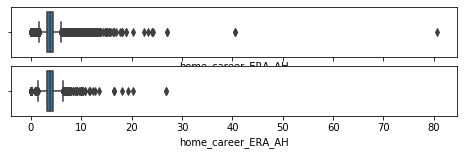

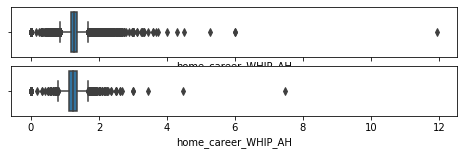

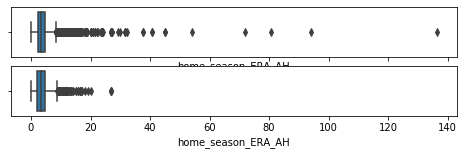

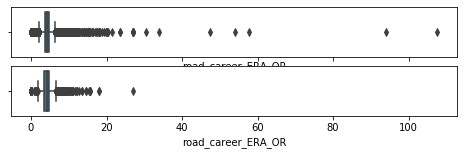

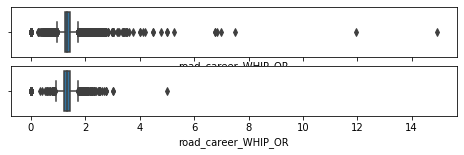

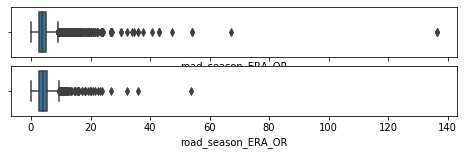

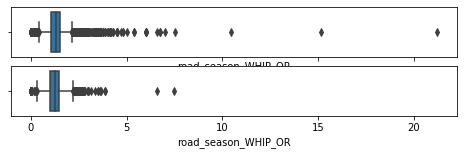

In [49]:
#view distributions of pitching statistics
pitching_stats = ['home_career_ERA_AH', 'home_career_WHIP_AH', 'home_season_ERA_AH', 'road_career_ERA_OR',
                 'road_career_WHIP_OR', 'road_season_ERA_OR', 'road_season_WHIP_OR']

for feature in pitching_stats:
    
    fig, (ax1, ax2) = plt.subplots(2, figsize = (8, 2), sharex = True)
    
    sns.boxplot(x = xtrain[feature], ax = ax1)
    
    sns.boxplot(x = xtest[feature], ax = ax2)

In [50]:
xtrain_problem_indices = xtrain[(xtrain.road_season_WHIP_OR > 7) | 
                               (xtrain.road_season_ERA_OR > 30) |
                               (xtrain.road_career_WHIP_OR > 6) |
                               (xtrain.road_career_ERA_OR > 30) |
                               (xtrain.home_season_ERA_AH > 30) |
                               (xtrain.home_career_WHIP_AH > 6) | 
                               (xtrain.home_career_ERA_AH > 30)].index

xtest_problem_indices = xtest[(xtest.road_season_WHIP_OR > 7) | 
                           (xtest.road_season_ERA_OR > 30) |
                           (xtest.road_career_WHIP_OR > 6) |
                           (xtest.road_career_ERA_OR > 30) |
                           (xtest.home_season_ERA_AH > 30) |
                           (xtest.home_career_WHIP_AH > 6) | 
                           (xtest.home_career_ERA_AH > 30)].index

print(len(xtrain_problem_indices), len(xtest_problem_indices))

40 4


In [51]:
xtrain = xtrain.drop(xtrain_problem_indices, axis = 0)

xtest = xtest.drop(xtest_problem_indices, axis = 0)

In [52]:
game1s = xtrain[(xtrain.home_OBPS == 0.) | (xtrain.road_OBPS == 0.)]
game1s_ = xtest[(xtest.home_OBPS == 0.) | (xtest.road_OBPS ==0.)]

print(len(game1s), len(game1s_))

0 0


In [56]:
xtrain = xtrain.reset_index(drop = True)
xtest = xtest.reset_index(drop = True)

ytrain = ytrain.drop(xtrain_problem_indices, axis = 0).reset_index(drop = True)
ytest = ytest.drop(xtest_problem_indices, axis = 0).reset_index(drop = True)

In [57]:
len(xtrain), len(xtest), len(ytrain), len(ytest)

(21457, 2384, 21457, 2384)

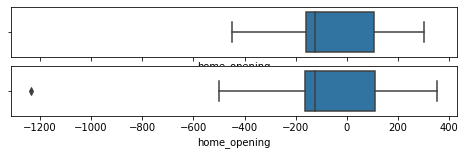

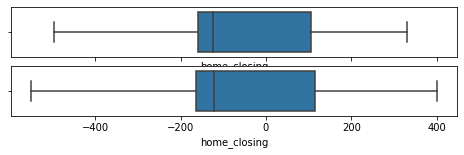

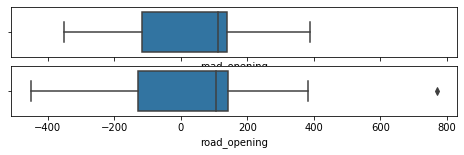

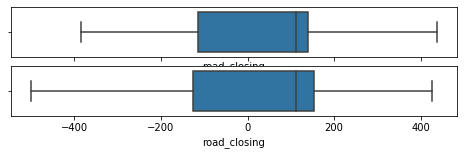

In [58]:
#view distributions of odds features
odds_features = ['home_opening', 'home_closing', 'road_opening', 'road_closing']
for feature in odds_features:
    
    fig, (ax1, ax2) = plt.subplots(2, figsize = (8, 2), sharex = True)
    
    sns.boxplot(x = xtrain[feature], ax = ax1)
    
    sns.boxplot(x = xtest[feature], ax = ax2)

An idea: get rid of home opening and road opening stats altogether. Instead, create a new feature determining line movement - Is the money on the home side or the road side.

In [59]:
xtrain[["home_opening", "home_closing", "road_opening", "road_closing"]].head()

,home_opening,home_closing,road_opening,road_closing
0,-135.0,-134.0,120.0,119.0
1,-170.0,-142.0,150.0,127.0
2,-125.0,-139.0,110.0,124.0
3,-140.0,-158.0,125.0,143.0
4,-150.0,-125.0,135.0,110.0


In [60]:
def money_movement(df):
    
    direction = []
    
    quantity = []
    
    for k in range(len(df)):
        
        if df.iloc[k]["home_opening"] < 0:
            
            if df.iloc[k]["home_closing"] < df.iloc[k]["home_opening"]:
                
                direction.append(1)
                
                quantity.append(df.iloc[k]["home_closing"] - df.iloc[k]["home_opening"])
                
            elif df.iloc[k]["home_closing"] > df.iloc[k]["home_opening"]:
                
                direction.append(-1)
                
                if df.iloc[k]["home_closing"] > 0:
                    
                    quantity.append((-1*df.iloc[k]["home_opening"] - 100) +\
                                   (df.iloc[k]["home_closing"] - 100))
                else:
                    
                    quantity.append(df.iloc[k]["home_closing"] - df.iloc[k]["home_opening"])
                
            else:
                
                direction.append(0)
                
                quantity.append(0)
                
        else:
            
            if df.iloc[k]["home_closing"] < df.iloc[k]["home_opening"]:
                
                direction.append(1)
                
                if df.iloc[k]["home_closing"] < 0:
                    
                    quantity.append((df.iloc[k]["home_closing"] + 100) - (df.iloc[k]["home_opening"] - 100))
                    
                else:
                    
                    quantity.append(df.iloc[k]["home_closing"] - df.iloc[k]["home_opening"])
                    
            elif df.iloc[k]["home_closing"] > df.iloc[k]["home_opening"]:
                
                direction.append(-1)
                
                quantity.append(df.iloc[k]["home_closing"] - df.iloc[k]["home_opening"])
                
            else:
                
                direction.append(0)
                
                quantity.append(0)
                
    return(direction, quantity)

In [61]:
direction, scalar = money_movement(xtrain)
_direction, _scalar = money_movement(xtest)

direction_train = pd.Series(direction).rename("line_movement")
direction_test = pd.Series(_direction).rename("line_movement")

scalar_train = pd.Series(scalar).rename("money_scalar")
scalar_test = pd.Series(_scalar).rename("money_scalar")

In [62]:
xtrain = xtrain.drop(columns = ["home_opening", "road_opening"]).reset_index(drop = True)
xtest = xtest.drop(columns = ["home_opening", "road_opening"]).reset_index(drop = True)

xtrain = pd.concat([xtrain, scalar_train], axis = 1)
xtest = pd.concat([xtest, scalar_test], axis = 1)

home_closing = xtest["home_closing"].values
road_closing = xtest["road_closing"].values

scaledXtrain, ss = PrepTools(xtrain, ytrain).scale_features(save_scaler = True)

scaledXtest = PrepTools(xtest, ytest).scale_features(load_scaler = ss)

In [63]:
scaledXtrain = pd.concat([scaledXtrain, direction_train], axis = 1)
scaledXtest = pd.concat([scaledXtest, direction_test], axis = 1)

scaledXtrain.head()

,home_OBPS,home_AVG_RUNS,home_AVG_H,home_BULLPEN_ERA,home_BULLPEN_WHIP,road_OBPS,road_AVG_RUNS,road_AVG_H,road_BULLPEN_ERA,road_BULLPEN_WHIP,home_career_ERA_AH,home_career_WHIP_AH,road_career_ERA_OR,road_career_WHIP_OR,road_season_ERA_OR,road_season_WHIP_OR,current_streak_hm_tm,current_streak_hm_at_hm,home_record_hm,run_differential_hm,avg_margin_hm,current_streak_rd_tm,current_streak_rd_tm_on_rd,rd_record_rd,run_differential_rd,avg_margin_rd,home_closing,road_closing,home_season_ERA_AH,money_scalar,line_movement
0,3.718988,4.995417,3.465299,0.368171,1.654970,4.231564,3.272892,3.664342,4.571798,7.453765,-0.448549,0.165629,0.027389,0.082651,-1.491638,-2.240038,0.442852,0.283943,-0.206019,-0.075187,2.051264,-0.270042,-0.275721,0.206522,0.070653,-1.965740,-0.476316,0.587726,-1.450481,0.089758,-1
1,-0.044428,1.751719,-0.530192,4.108280,-1.328760,-2.376170,-1.537788,-3.986935,-2.836959,-1.477568,0.861619,0.800822,0.031503,-0.182050,-1.491638,-2.240038,0.442852,0.283943,-0.206019,-0.048206,3.108479,-0.270042,-0.275721,0.206522,0.044898,-2.984086,-0.536321,0.645789,-1.450481,1.492675,-1
2,2.042375,1.751719,0.468681,-2.842223,-1.328760,-1.067646,-1.537788,-1.800856,1.123278,-0.577384,0.439887,0.349031,0.178192,0.286839,-1.491638,-2.240038,0.442852,0.283943,-0.206019,-0.048206,3.108479,-0.270042,-0.275721,0.206522,0.044898,-2.984086,-0.513819,0.624015,-1.450481,-0.689640,1
3,1.293390,-1.491979,3.465299,0.633028,3.510023,1.421698,0.867552,1.478263,1.558904,1.505129,0.104610,0.107704,-0.065438,0.219004,-1.491638,-2.240038,-0.408568,-0.506119,-0.443040,-0.183112,-2.177596,0.662792,0.495415,0.446170,0.173676,2.107645,-0.656333,0.761916,-1.450481,-0.897479,1
4,-2.962921,-1.491979,-3.526809,-2.842223,1.090631,-0.004941,0.867552,-2.893895,-2.836959,-0.191040,0.555889,0.539999,0.304224,0.689630,-1.491638,-2.240038,-0.408568,-0.506119,-0.443040,-0.183112,-2.177596,0.662792,0.495415,0.446170,0.173676,2.107645,-0.408810,0.522405,-1.450481,1.336795,-1


In [64]:
scaledXtrain.to_csv("./neural_net/working_xtrain.csv.gz", index = False, compression = "gzip")
scaledXtest.to_csv("./neural_net/working_xtest.csv.gz", index = False, compression = "gzip")

ytrain.to_csv("./neural_net/working_ytrain.csv.gz", index = False, compression = "gzip")
ytest.to_csv("./neural_net/working_ytest.csv.gz", index = False, compression = "gzip")

# READ BACK IN WORKING DATASETS HERE

In [4]:
scaledXtrain = pd.read_csv("./neural_net/working_xtrain.csv.gz", compression = "gzip")
scaledXtest = pd.read_csv("./neural_net/working_xtest.csv.gz", compression = "gzip")

ytrain = pd.read_csv("./neural_net/working_ytrain.csv.gz", compression = "gzip")
ytest = pd.read_csv("./neural_net/working_ytest.csv.gz", compression = "gzip")

In [65]:
npX_train = scaledXtrain.values

npX_test = scaledXtest.values

npY_train_multi = ytrain.values

npY_test_multi = ytest.values

npY_train_dual = ytrain.drop(columns = ["no_bet"]).values

npY_test_dual = ytest.drop(columns = ["no_bet"]).values

npY_train_relu = ytrain.drop(columns = ["road_win", "no_bet"]).values

npY_test_relu = ytest.drop(columns = ["road_win", "no_bet"]).values

In [66]:
bankroll_y = ytest["home_win"].values

In [3]:
@dataclass
class NeuralNetConstructor():
    training: np.ndarray
    train_target: np.ndarray
    validation: np.ndarray = None
    validation_target: np.ndarray = None
    external_validation: bool = False
    objective: str = "binary"
    n_classes: int = None
    n_hidden: int = 2
    base_neurons: int = 500
    shape: str = "funnel"
    funnel_param: float = 0.25
    dropout: bool = False
    dropout_pct: float = 0.5
    normalize_batches: bool = False
    model_checkpoint: bool = False
    checkpoint_params: dict = field(default_factory = dict)
    early_stopping: bool = False
    early_stopping_params: dict = field(default_factory = dict)
    activation: str = "relu"
    compile_params: dict = field(default_factory = dict)
    fit_params: dict = field(default_factory = dict)
    
    def train_model(self):
        
        self.create_callbacks()
        
        if self.external_validation:
            
                self.fit_params.update({"validation_data" : (self.validation, self.validation_target)})
        
        model = self.create_model_architecture()
        
        history = model.fit(self.training, self.train_target, **self.fit_params)
        
        return(model, history)
    
    def create_model_architecture(self):
        
        input_dim = self.training.shape[1]
        
        model = Sequential()
        
        model.add(Dense(self.base_neurons, activation = self.activation,
                       input_shape = (input_dim,)))
        
        if self.normalize_batches:
            
            model.add(BatchNormalization())
        
        if self.dropout:
            
            model.add(Dropout(self.dropout_pct))
            
        for _ in range(self.n_hidden):
            
            if self.normalize_batches:
                
                model.add(BatchNormalization())
                
            if self.dropout:
                
                model.add(Dropout(self.dropout_pct))
                
            if self.shape == "funnel":
                
                self.base_neurons = int(self.base_neurons * self.funnel_param)
                
                model.add(Dense(self.base_neurons, activation = self.activation))
                
            elif self.shape == "rectangle":
                
                model.add(Dense(self.base_neurons, activation = self.activation))
                
            else:
                
                raise ValueError("Unsupported network shape provided")
                
        if self.objective == "binary":
            
            model.add(Dense(1, activation = "sigmoid"))
            
        else:
            
            if not self.n_classes:
                
                raise ValueError("If objective is not binary, must pass n_classes")
            
            else:
            
                model.add(Dense(self.n_classes, activation = "softmax"))
        
        model.compile(**self.compile_params)
            
        return(model)
    
    def create_callbacks(self):
        
        if self.early_stopping and self.model_checkpoint:
            
            early_stopping_monitor = EarlyStopping(**self.early_stopping_params)
            
            model_checkpointer = ModelCheckpoint(**self.checkpoint_params)
            
            self.fit_params.update({"callbacks" : [early_stopping_monitor, model_checkpointer]})
            
        elif self.early_stopping:
            
            early_stopping_monitor = EarlyStopping(**self.early_stopping_params)
            
            self.fit_params.update({"callbacks" : [early_stopping_monitor]})
            
        elif self.model_checkpoint:
            
            model_checkpointer = ModelCheckpoint(**self.checkpoint_params)
            
            self.fit_params.update({"callbacks" : [model_checkpointer]})
            
    @staticmethod
    def plot_loss(model_history):
        
        fig, ax = plt.subplots(1, 1, figsize = (10, 6))
        
        ax.plot((model_history.history['loss']), 'r', label='train')
        
        ax.plot((model_history.history['val_loss']), 'b' ,label='val')
        
        ax.set_xlabel(r'Epoch', fontsize=20)
        
        ax.set_ylabel(r'Loss', fontsize=20)
        
        ax.legend()
        
        ax.tick_params(labelsize=20);

In [4]:
def gambling_loss_binary(ytrue, ypreds):
    ''' 
    Callable to calculate gambling loss. Binary classification. Using two labels with softmax for calculation
    purposes as opposed to sigmoid with single output.
    '''
    home_win = ytrue[:, 0:1]
    
    road_win = ytrue[:, 1:2]
    
    odds_home = ytrue[:, 2:3]
    
    odds_road = ytrue[:, 3:4]
    
    profit_tensor = K.concatenate([home_win * (odds_home - 1) + (1 - home_win) * -1,
                                  road_win * (odds_road - 1) + (1 - road_win) * -1],
                                 axis = 1)
    
    return(-1 * K.mean(K.sum(profit_tensor * ypreds, axis = 1)))
    

def gambling_loss_multiclass(ytrue, ypreds):
    '''
    Callable to calculate gambling loss. 3 class multi-class classification. Adding logic for NO BET
    '''
    home_win = ytrue[:, 0:1]
    
    road_win = ytrue[:, 1:2]
    
    odds_home = ytrue[:, 3:4]
    
    odds_road = ytrue[:, 4:5]
    
    profit_tensor = K.concatenate([home_win * (odds_home - 1) + (1 - home_win) * -1,
                                  road_win * (odds_road - 1) + (1 - road_win) * -1,
                                  K.zeros_like(odds_home)], axis = 1)
    
    return(-1 * K.mean(K.sum(profit_tensor * ypreds, axis = 1)))

def gambling_loss_ReLu(ytrue, ypreds): ##THIS HAS BEEN IMPLEMENTED WRONG THE WHOLE TIME
    '''
    Callable to calculate gambling loss using ReLu function to simulate gambling strategy 
    '''
    home_win = ytrue[:, 0:1]
    
    odds_home = ytrue[:, 1:2]
    
    odds_road = ytrue[:, 2:3]
    
    return(-K.sum((home_win * (odds_home - 1)) * K.relu(ypreds * (odds_home - 1)) +\
    ((1 - home_win) * (odds_road - 1)) * K.relu((1 - ypreds) * (odds_road - 1))))

## LOSS FUNCTION TESTING - WANT TO ENSURE THESE ARE ACTING PROPERLY

In [6]:
sample_y_binary = K.variable([[1, 1.85, 2.07],
                             [1, 1.80, 2.10],
                             [0, 1.95, 1.95],
                             [1, 1.78, 2.13],
                             [1, 1.67, 2.35]])
sample_pred_binary = K.variable([[0.6], [0.3], [0.4], [0.7], [0.6]])

sample_y_dual = K.variable([[1, 0, 1.85, 2.07],
                             [1, 0, 1.80, 2.10],
                             [0, 1, 1.95, 1.95],
                             [1, 0, 1.78, 2.13],
                             [1, 0, 1.67, 2.35]])
sample_pred_dual = K.variable([[0.6, 0.4], [0.3, 0.7], [0.4, 0.6], [0.7, 0.3], [0.6, 0.4]])

sample_y_tri = K.variable([[1, 0, 0, 1.85, 2.07],
                          [1, 0, 0, 1.80, 2.10],
                          [0, 1, 0, 1.95, 1.95],
                          [1, 0, 0, 1.78, 2.13],
                          [1, 0, 0, 1.67, 2.35]])
sample_pred_tri = K.variable([[0.6, 0.3, 0.1], [0.3, 0.6, 0.1], [0.7, 0.2, 0.1],
                             [0.7, 0.7, 0.0], [0.5, 0.4, 0.1]])

In [7]:
K.eval(gambling_loss_ReLu(sample_y_binary, sample_pred_binary))

-1.86222

In [8]:
K.eval(gambling_loss_binary(sample_y_dual, sample_pred_dual))

-0.013600004

In [9]:
K.eval(gambling_loss_multiclass(sample_y_tri, sample_pred_tri))

0.17580001

Appear to be working fine. TBD which will yield greatest results in training / testing.

In [28]:
nn_params = {
    
    "training" : npX_train,
    
    "train_target" : npY_train_relu,
    
    "validation" : npX_test,
    
    "validation_target" : npY_test_relu,
    
    "external_validation" : True,
    
    "base_neurons" : 100,
    
    "early_stopping" : True,
    
    "early_stopping_params" : {
        
        "monitor" : "val_loss",
        
        "patience" : 25,
        
        "mode" : "min",
        
        "restore_best_weights" : True
    },
    
    "compile_params" : {
        
        "optimizer" : "adam",
        
        "loss" : gambling_loss_ReLu
    },
    
    "fit_params" : {
        
        "epochs" : 10,
        
        "batch_size" : 64,
        
        "verbose" : 1
    }
}

nn = NeuralNetConstructor(**nn_params)

Train on 21497 samples, validate on 2388 samples
Epoch 1/10
21497/21497 [==============================] - 1s 37us/sample - loss: -45.5612 - val_loss: -55.0885
Epoch 2/10
21497/21497 [==============================] - 0s 21us/sample - loss: -47.8997 - val_loss: -55.0039
Epoch 3/10
21497/21497 [==============================] - 0s 22us/sample - loss: -48.0034 - val_loss: -54.8452
Epoch 4/10
21497/21497 [==============================] - 0s 20us/sample - loss: -48.1511 - val_loss: -54.8091
Epoch 5/10
21497/21497 [==============================] - 0s 21us/sample - loss: -48.2099 - val_loss: -55.0470
Epoch 6/10
21497/21497 [==============================] - 0s 20us/sample - loss: -48.2355 - val_loss: -55.1617
Epoch 7/10
21497/21497 [==============================] - 0s 21us/sample - loss: -48.3354 - val_loss: -54.9647
Epoch 8/10
21497/21497 [==============================] - 0s 20us/sample - loss: -48.3479 - val_loss: -54.9885
Epoch 9/10
21497/21497 [==============================] - 0s 20

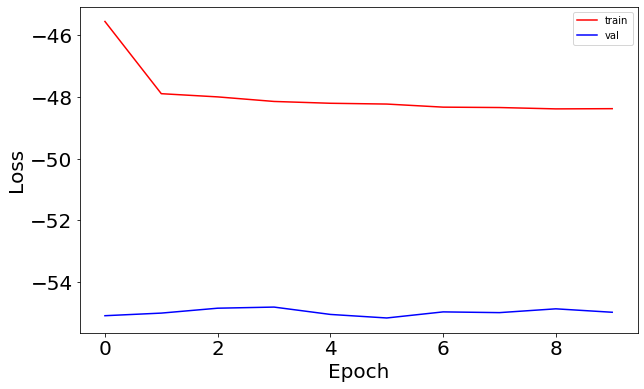

In [215]:
nn_model, nn_history = nn.train_model()

nn.plot_loss(nn_history)

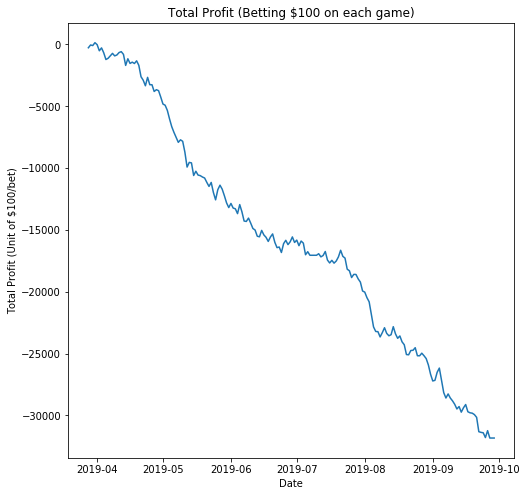

In [216]:
nn_preds = nn_model.predict(npX_test)

bc = BankrollCalculator(nn_preds, bankroll_y, validation_dates, home_closing, road_closing)

bc.plot_profit()

In [35]:
nn_json = nn_model.to_json()

with open("./neural_net/best_model_REVERSE.json", "w+") as f:
    json.dump(nn_json, f)
    
nn_model.save_weights("./neural_net/best_model_REVERSE.h5")

In [217]:
flip_nn = [0 if i > 0.5 else 1 for i in nn_preds]

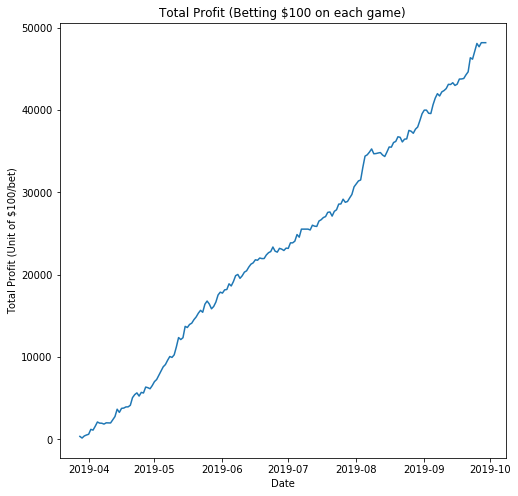

In [218]:
bc = BankrollCalculator(flip_nn, bankroll_y, validation_dates, home_closing, road_closing)

bc.plot_profit()

In [221]:
faulty_results = pd.Series(flip_nn).rename("bet_pred")

ytest = pd.concat([ytest, faulty_results], axis = 1)

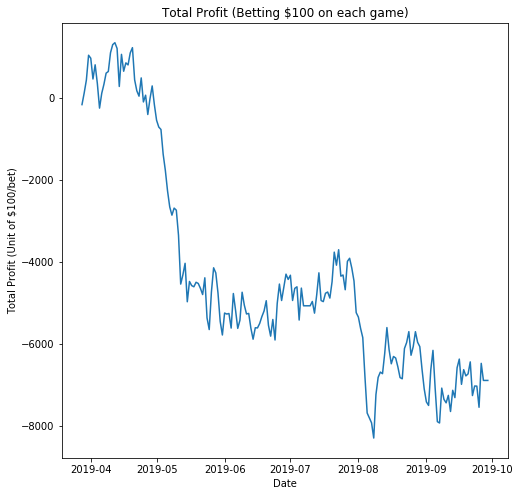

In [223]:
bc = BankrollCalculator(nn_preds, bankroll_y, validation_dates, home_closing_new, road_closing_new)

bc.plot_profit()

WOW. BIG TIME RESULTS. NEED TO DO SOME INVESTIGATION INTO WHETHER OR NOT THESE ARE LEGIT. UPDATE: THEY AREN'T.

In [119]:
x_prep = PrepTools(scaledXtrain, ytrain["home_win"])

In [120]:
highly_correlated = x_prep.feature_frame_correlation(tol = 0.75)

In [121]:
highly_correlated

home_closing          road_closing               0.922141
home_OBPS             home_AVG_RUNS              0.895768
rd_record_rd          run_differential_rd        0.881230
road_OBPS             road_AVG_RUNS              0.858850
home_record_hm        run_differential_hm        0.853676
road_season_ERA_OR    road_season_WHIP_OR        0.842892
home_OBPS             home_AVG_H                 0.842351
road_career_ERA_OR    road_career_WHIP_OR        0.834343
home_career_ERA_AH    home_career_WHIP_AH        0.829328
road_OBPS             road_AVG_H                 0.826451
road_BULLPEN_ERA      road_BULLPEN_WHIP          0.795990
current_streak_hm_tm  current_streak_hm_at_hm    0.791859
home_BULLPEN_ERA      home_BULLPEN_WHIP          0.790265
home_AVG_RUNS         home_AVG_H                 0.768924
road_AVG_RUNS         road_AVG_H                 0.752849
dtype: float64

In [123]:
target_corr = x_prep.get_correlation_with_target(target_name = "home_win")

In [124]:
target_corr

road_closing                home_win    0.113913
home_closing                home_win    0.110605
run_differential_rd         home_win    0.062407
rd_record_rd                home_win    0.058012
home_record_hm              home_win    0.055749
run_differential_hm         home_win    0.052922
money_scalar                home_win    0.042726
line_movement               home_win    0.036171
road_AVG_RUNS               home_win    0.029423
avg_margin_rd               home_win    0.028539
avg_margin_hm               home_win    0.026085
road_OBPS                   home_win    0.025695
home_OBPS                   home_win    0.024910
current_streak_rd_tm_on_rd  home_win    0.024511
home_BULLPEN_WHIP           home_win    0.022945
current_streak_hm_at_hm     home_win    0.022873
road_BULLPEN_WHIP           home_win    0.022860
current_streak_rd_tm        home_win    0.021969
home_AVG_RUNS               home_win    0.021670
current_streak_hm_tm        home_win    0.020925
home_season_ERA_AH  

In [125]:
high_VIF = x_prep.recursive_VIF()

In [126]:
high_VIF

[('home_OBPS', 7.625839006511084),
 ('home_closing', 6.889682687999187),
 ('road_OBPS', 5.4628718206076465),
 ('run_differential_rd', 5.423371524235878)]

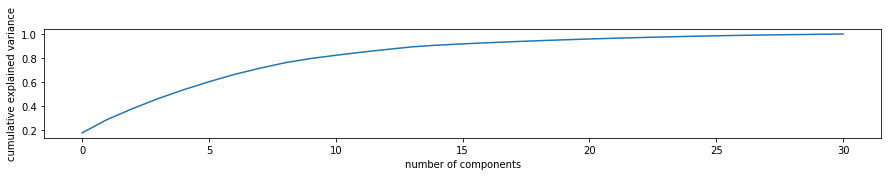

In [127]:
pca = PCA().fit(scaledXtrain)

plt.figure(figsize = (15, 2))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [128]:
explained_variance = pd.DataFrame(pca.explained_variance_ratio_)
explained_variance = explained_variance.rename(columns = {0 : 'var_proportion'})

explained_variance['total_variance_explained'] = explained_variance.var_proportion.cumsum()
explained_variance

,var_proportion,total_variance_explained
0,0.179493,0.179493
1,0.112021,0.291514
2,0.090028,0.381542
3,0.082811,0.464353
4,0.072791,0.537144
5,0.066534,0.603678
6,0.060689,0.664367
7,0.051144,0.715511
8,0.046158,0.761669
9,0.034696,0.796365


# CREATE NEW DATAFRAMES... HOPEFULLY ONE OF THESE CAN GIVE US SOME REAL RESULTS

## PCA- 90% of variance

In [129]:
pca90 = PCA(n_components = 15)

pca90.fit(scaledXtrain)

pca90train, pca90test = pca90.transform(scaledXtrain), pca90.transform(scaledXtest)

## PCA- 95% of variance

In [130]:
pca95 = PCA(n_components = 20)

pca95.fit(scaledXtrain)

pca95train, pca95test = pca95.transform(scaledXtrain), pca95.transform(scaledXtest)

## VIF REDUCED

In [131]:
drop_VIF = ["home_OBPS", "road_OBPS", "home_closing", "run_differential_rd"]

npX_train_VIF = scaledXtrain.drop(columns = drop_VIF).values
npX_test_VIF = scaledXtest.drop(columns = drop_VIF).values

# ACTIVE MODELING

In [147]:
nn_params = {
    
    "training" : npX_train_VIF,
    
    "train_target" : npY_train_relu,
    
    "validation" : npX_test_VIF,
    
    "validation_target" : npY_test_relu,
    
    "objective" : "binary",
    
    "n_classes" : 1,
    
    "n_hidden": 1,
    
    "external_validation" : True,
    
    "base_neurons" : 100,
    
    "shape" : "rectangle",
    
    "normalize_batches" : True,
    
    "early_stopping" : True,
    
    "early_stopping_params" : {
        
        "monitor" : "val_loss",
        
        "patience" : 25,
        
        "mode" : "min",
        
        "restore_best_weights" : True
    },
    
    "compile_params" : {
        
        "optimizer" : "adam",
        
        "loss" : gambling_loss_ReLu
    },
    
    "fit_params" : {
        
        "epochs" : 20,
        
        "batch_size" : 2056,
        
        "verbose" : 1
    }
}

nn = NeuralNetConstructor(**nn_params)

Train on 21457 samples, validate on 2384 samples
Epoch 1/20
21457/21457 [==============================] - 1s 32us/sample - loss: -1188.4815 - val_loss: -1217.4830
Epoch 2/20
21457/21457 [==============================] - 0s 4us/sample - loss: -1309.2406 - val_loss: -1300.8493
Epoch 3/20
21457/21457 [==============================] - 0s 4us/sample - loss: -1355.6994 - val_loss: -1343.0208
Epoch 4/20
21457/21457 [==============================] - 0s 4us/sample - loss: -1375.5789 - val_loss: -1371.6585
Epoch 5/20
21457/21457 [==============================] - 0s 4us/sample - loss: -1391.5752 - val_loss: -1395.7453
Epoch 6/20
21457/21457 [==============================] - 0s 4us/sample - loss: -1396.2890 - val_loss: -1415.7651
Epoch 7/20
21457/21457 [==============================] - 0s 4us/sample - loss: -1400.5537 - val_loss: -1427.5954
Epoch 8/20
21457/21457 [==============================] - 0s 3us/sample - loss: -1406.6608 - val_loss: -1436.0596
Epoch 9/20
21457/21457 [==============

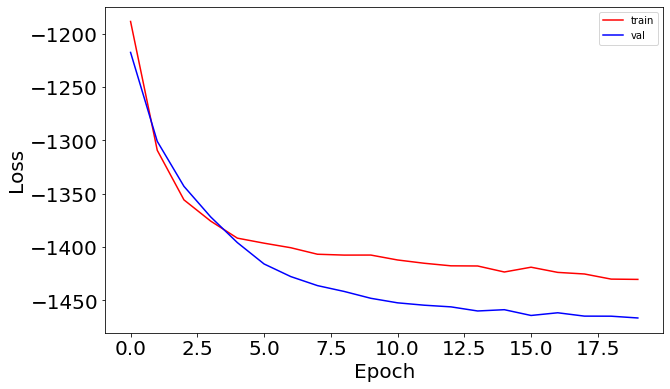

In [148]:
_model, _history = nn.train_model()

nn.plot_loss(_history)

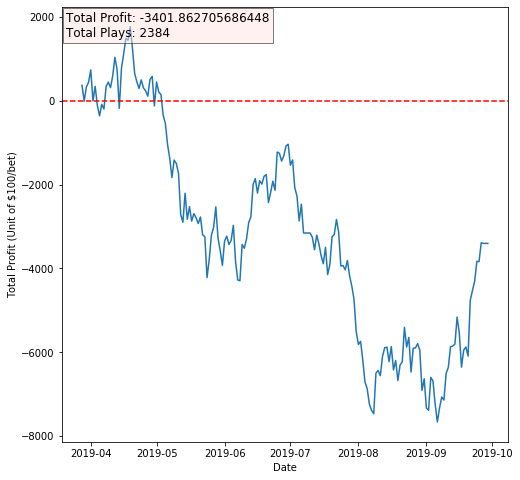

In [149]:
_preds = _model.predict(npX_test_VIF)

bc = BankrollCalculator(_preds, bankroll_y, validation_dates, home_closing, road_closing)

bc.plot_profit()

In [145]:
_flip = [0 if i > 0.5 else 1 for i in _preds]

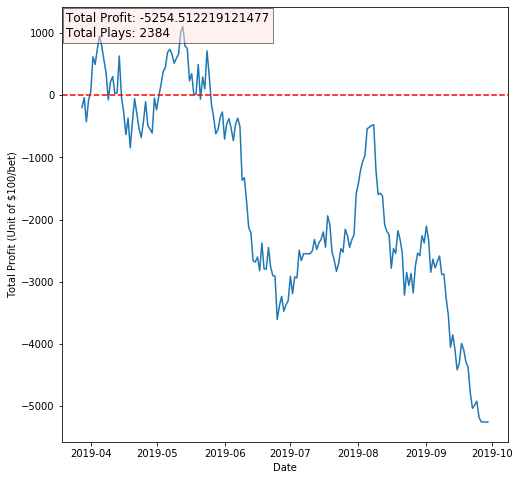

In [146]:
bc = BankrollCalculator(_flip, bankroll_y, validation_dates, home_closing, road_closing)

bc.plot_profit()

# ADVANCED METRIC MODELING

In [11]:
df = pd.read_csv("./adv_metrics/all_metrics_with_odds.csv.gz", compression = "gzip", low_memory = False)

pd.set_option("max.columns", 200)

df.head()

,date,home_close_TJ,home_close_ou,home_closing,home_open_TJ,home_open_ou,home_opening,home_runline,home_runline_juice,is_doubleheader,road_close_TJ,road_close_ou,road_closing,road_open_TJ,road_open_ou,road_opening,road_runline,road_runline_juice,is_tripleheader,season,home_team,road_team,home_starter,road_starter,home_wOBA,home_wRAA,home_wRC,home_OPS,home_relief_wOBA,home_relief_wRAA,home_relief_wRC,home_relief_FIP,home_relief_WHIP,home_relief_ERA,home_relief_K_BB,home_relief_K_9,home_starter_career_wOBA,home_starter_career_wRAA,home_starter_career_wRC,home_starter_career_FIP,home_starter_career_WHIP,home_starter_career_ERA,home_starter_careerK/BB,home_starter_careerK/9,home_starter_career_AVGIP,home_starter_season_wOBA,home_starter_season_wRAA,home_starter_season_wRC,home_starter_season_FIP,home_starter_season_WHIP,home_starter_season_ERA,home_starter_seasonK/BB,home_starter_seasonK/9,home_starter_seasonAVG_IP,road_wOBA,road_wRAA,road_wRC,road_OPS,road_relief_wOBA,road_relief_wRAA,road_relief_wRC,road_relief_FIP,road_relief_WHIP,road_relief_ERA,road_relief_K_BB,road_relief_K_9,road_starter_career_wOBA,road_starter_career_wRAA,road_starter_career_wRC,road_starter_career_FIP,road_starter_career_WHIP,road_starter_career_ERA,road_starter_careerK/BB,road_starter_careerK/9,road_starter_career_AVGIP,road_starter_season_wOBA,road_starter_season_wRAA,road_starter_season_wRC,road_starter_season_FIP,road_starter_season_WHIP,road_starter_season_ERA,road_starter_seasonK/BB,road_starter_seasonK/9,road_starter_seasonAVG_IP,home_payout,road_payout,elo1_pre,elo2_pre,rating1_pre,rating2_pre,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,score1,score2,home_win,home_favorite
0,2010-04-04,-115,9,-117.0,-104,9.0,-114,NaN,NaN,0,-105,9,107.0,-116,9.0,104,NaN,NaN,0.0,2010.0,BOS,NYY,beckj002,sabac001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.854701,2.070000,1537.262,1568.875,1536.601,1562.673,57.031,61.828,27.349300,46.7039,0.471714,9.0,7.0,1,1
1,2010-04-05,105,7.5,175.0,-120,7.5,175,NaN,NaN,0,-125,7.5,-200.0,100,7.5,-200,NaN,NaN,0.0,2010.0,WSN,PHI,lannj001,hallr001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.750000,1.500000,1460.859,1541.211,1460.662,1537.875,49.834,62.166,8.394200,49.4957,0.366599,1.0,11.0,0,0
2,2010-04-05,-105,7,137.0,-105,7.0,110,NaN,NaN,0,-115,7,-152.0,-115,7.0,-125,NaN,NaN,0.0,2010.0,OAK,SEA,sheeb001,hernf002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.370000,1.657895,1509.222,1501.778,1513.910,1500.945,56.701,60.524,7.593298,46.4172,0.501246,3.0,5.0,0,0
3,2010-04-05,110,8.5,-128.0,100,8.5,-135,NaN,NaN,0,-130,8.5,113.0,-120,8.5,120,NaN,NaN,0.0,2010.0,ANA,MIN,weavj003,bakes002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.781250,2.130000,1544.703,1521.978,1543.114,1520.771,54.034,55.637,16.337200,26.8276,0.550540,6.0,3.0,1,1
4,2010-04-05,-115,7,-122.0,-115,7.0,-115,NaN,NaN,0,-105,7,112.0,-105,7.0,105,NaN,NaN,0.0,2010.0,KCR,DET,greiz001,verlj001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.819672,2.120000,1476.779,1502.086,1478.280,1500.407,63

In [15]:
try:
    
    df.home_opening = df.home_opening.astype("float32")
    
except Exception as e:
    
    print(e)

could not convert string to float: 'NL'


In [19]:
probs

Int64Index([21768, 21824, 21850, 21954, 21990], dtype='int64')

In [21]:
probs = df[df.home_opening == "NL"].index

for k in probs:
    
    df.at[k, "home_opening"] = df.iloc[k]["home_closing"]
    
probs = df[df.road_opening == "NL"].index

for k in probs:
    
    df.at[k, "road_opening"] = df.iloc[k]["road_closing"]
    
df.home_opening = df.home_opening.astype("float32")

df.road_opening = df.road_opening.astype("float32")

In [22]:
def money_movement(df):
    
    direction = []
    
    quantity = []
    
    for k in range(len(df)):
        
        if df.iloc[k]["home_opening"] < 0:
            
            if df.iloc[k]["home_closing"] < df.iloc[k]["home_opening"]:
                
                direction.append(1)
                
                quantity.append(df.iloc[k]["home_closing"] - df.iloc[k]["home_opening"])
                
            elif df.iloc[k]["home_closing"] > df.iloc[k]["home_opening"]:
                
                direction.append(-1)
                
                if df.iloc[k]["home_closing"] > 0:
                    
                    quantity.append((-1*df.iloc[k]["home_opening"] - 100) +\
                                   (df.iloc[k]["home_closing"] - 100))
                else:
                    
                    quantity.append(df.iloc[k]["home_closing"] - df.iloc[k]["home_opening"])
                
            else:
                
                direction.append(0)
                
                quantity.append(0)
                
        else:
            
            if df.iloc[k]["home_closing"] < df.iloc[k]["home_opening"]:
                
                direction.append(1)
                
                if df.iloc[k]["home_closing"] < 0:
                    
                    quantity.append((df.iloc[k]["home_closing"] + 100) - (df.iloc[k]["home_opening"] - 100))
                    
                else:
                    
                    quantity.append(df.iloc[k]["home_closing"] - df.iloc[k]["home_opening"])
                    
            elif df.iloc[k]["home_closing"] > df.iloc[k]["home_opening"]:
                
                direction.append(-1)
                
                quantity.append(df.iloc[k]["home_closing"] - df.iloc[k]["home_opening"])
                
            else:
                
                direction.append(0)
                
                quantity.append(0)
                
    return(direction, quantity)

In [23]:
direction, scalar = money_movement(df)

direction_train = pd.Series(direction).rename("line_movement")

scalar_train = pd.Series(scalar).rename("money_scalar")

In [24]:
df = pd.concat([df, direction_train, scalar_train], axis = 1)

In [25]:
df.head()

,date,home_close_TJ,home_close_ou,home_closing,home_open_TJ,home_open_ou,home_opening,home_runline,home_runline_juice,is_doubleheader,road_close_TJ,road_close_ou,road_closing,road_open_TJ,road_open_ou,road_opening,road_runline,road_runline_juice,is_tripleheader,season,home_team,road_team,home_starter,road_starter,home_wOBA,home_wRAA,home_wRC,home_OPS,home_relief_wOBA,home_relief_wRAA,home_relief_wRC,home_relief_FIP,home_relief_WHIP,home_relief_ERA,home_relief_K_BB,home_relief_K_9,home_starter_career_wOBA,home_starter_career_wRAA,home_starter_career_wRC,home_starter_career_FIP,home_starter_career_WHIP,home_starter_career_ERA,home_starter_careerK/BB,home_starter_careerK/9,home_starter_career_AVGIP,home_starter_season_wOBA,home_starter_season_wRAA,home_starter_season_wRC,home_starter_season_FIP,home_starter_season_WHIP,home_starter_season_ERA,home_starter_seasonK/BB,home_starter_seasonK/9,home_starter_seasonAVG_IP,road_wOBA,road_wRAA,road_wRC,road_OPS,road_relief_wOBA,road_relief_wRAA,road_relief_wRC,road_relief_FIP,road_relief_WHIP,road_relief_ERA,road_relief_K_BB,road_relief_K_9,road_starter_career_wOBA,road_starter_career_wRAA,road_starter_career_wRC,road_starter_career_FIP,road_starter_career_WHIP,road_starter_career_ERA,road_starter_careerK/BB,road_starter_careerK/9,road_starter_career_AVGIP,road_starter_season_wOBA,road_starter_season_wRAA,road_starter_season_wRC,road_starter_season_FIP,road_starter_season_WHIP,road_starter_season_ERA,road_starter_seasonK/BB,road_starter_seasonK/9,road_starter_seasonAVG_IP,home_payout,road_payout,elo1_pre,elo2_pre,rating1_pre,rating2_pre,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,score1,score2,home_win,home_favorite,line_movement,money_scalar
0,2010-04-04,-115,9,-117.0,-104,9.0,-114.0,NaN,NaN,0,-105,9,107.0,-116,9.0,104.0,NaN,NaN,0.0,2010.0,BOS,NYY,beckj002,sabac001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.854701,2.070000,1537.262,1568.875,1536.601,1562.673,57.031,61.828,27.349300,46.7039,0.471714,9.0,7.0,1,1,1,-3.0
1,2010-04-05,105,7.5,175.0,-120,7.5,175.0,NaN,NaN,0,-125,7.5,-200.0,100,7.5,-200.0,NaN,NaN,0.0,2010.0,WSN,PHI,lannj001,hallr001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.750000,1.500000,1460.859,1541.211,1460.662,1537.875,49.834,62.166,8.394200,49.4957,0.366599,1.0,11.0,0,0,0,0.0
2,2010-04-05,-105,7,137.0,-105,7.0,110.0,NaN,NaN,0,-115,7,-152.0,-115,7.0,-125.0,NaN,NaN,0.0,2010.0,OAK,SEA,sheeb001,hernf002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.370000,1.657895,1509.222,1501.778,1513.910,1500.945,56.701,60.524,7.593298,46.4172,0.501246,3.0,5.0,0,0,-1,27.0
3,2010-04-05,110,8.5,-128.0,100,8.5,-135.0,NaN,NaN,0,-130,8.5,113.0,-120,8.5,120.0,NaN,NaN,0.0,2010.0,ANA,MIN,weavj003,bakes002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.781250,2.130000,1544.703,1521.978,1543.114,1520.771,54.034,55.637,16.337200,26.8276,0.550540,6.0,3.0,1,1,-1,7.0
4,2010-04-05,-115,7,-122.0,-115,7.0,-115.0,NaN,NaN,0,-105,7,112.0,-105,7.0,105.0,NaN,NaN,0.0,2010.0,KCR,DET,greiz001,verlj001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

# WORKING DATASET - ELO

In [83]:
elo = df[["date","season","rating1_pre", "rating2_pre", "pitcher1_rgs", "pitcher2_rgs", "pitcher1_adj", 
          "pitcher2_adj",
             "rating_prob1", "home_win", "home_favorite", "line_movement", "money_scalar", "home_payout", 
              "road_payout", "home_closing", "road_closing"]]

In [84]:
elo.head()

,date,season,rating1_pre,rating2_pre,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,home_win,home_favorite,line_movement,money_scalar,home_payout,road_payout,home_closing,road_closing
0,2010-04-04,2010.0,1536.601,1562.673,57.031,61.828,27.349300,46.7039,0.471714,1,1,1,-3.0,1.854701,2.070000,-117.0,107.0
1,2010-04-05,2010.0,1460.662,1537.875,49.834,62.166,8.394200,49.4957,0.366599,0,0,0,0.0,2.750000,1.500000,175.0,-200.0
2,2010-04-05,2010.0,1513.910,1500.945,56.701,60.524,7.593298,46.4172,0.501246,0,0,-1,27.0,2.370000,1.657895,137.0,-152.0
3,2010-04-05,2010.0,1543.114,1520.771,54.034,55.637,16.337200,26.8276,0.550540,1,1,-1,7.0,1.781250,2.130000,-128.0,113.0
4,2010-04-05,2010.0,1478.280,1500.407,63.333,58.357,64.723700,40.3119,0.537755,0,1,1,-7.0,1.819672,2.120000,-122.0,112.0


In [85]:
elo_train = elo[elo.season < 2019]

elo_test = elo[elo.season == 2019].reset_index(drop = True)

In [66]:
elo_train_target = elo_train[["home_win", "home_payout", "road_payout"]]

elo_test_target = elo_test[["home_win", "home_payout", "road_payout"]]

In [67]:
add_back_train, add_back_test = elo_train[["home_favorite", "line_movement"]], elo_test[["home_favorite",
                                                                                      "line_movement"]]

elo_train, elo_test = elo_train.drop(columns = ["home_win", "home_favorite",
                                               "line_movement", "season"]), elo_test.drop(columns = ["home_win",
                                                                                          "home_favorite",
                                                                                          "line_movement",
                                                                                                    "season"])

In [68]:
xtrain, ss = PrepTools(elo_train, elo_train_target).scale_features(save_scaler = True)

In [70]:
xtest = PrepTools(elo_test, elo_test_target).scale_features(load_scaler = ss)

In [73]:
xtrain = pd.concat([xtrain, add_back_train], axis = 1)

xtest = pd.concat([xtest, add_back_test], axis = 1)

In [75]:
nn_params = {
    
    "training" : xtrain.values,
    
    "train_target" : elo_train_target.values,
    
    "validation" : xtest.values,
    
    "validation_target" : elo_test_target.values,
    
    "objective" : "binary",
    
    "n_classes" : 1,
    
    "n_hidden": 2,
    
    "external_validation" : True,
    
    "base_neurons" : 100,
    
    "shape" : "rectangle",
    
    "normalize_batches" : True,
    
    "early_stopping" : True,
    
    "early_stopping_params" : {
        
        "monitor" : "val_loss",
        
        "patience" : 25,
        
        "mode" : "min",
        
        "restore_best_weights" : True
    },
    
    "compile_params" : {
        
        "optimizer" : "adam",
        
        "loss" : gambling_loss_ReLu
    },
    
    "fit_params" : {
        
        "epochs" : 20,
        
        "batch_size" : 2056,
        
        "verbose" : 1
    }
}

nn = NeuralNetConstructor(**nn_params)

Train on 21555 samples, validate on 2384 samples
Epoch 1/20
21555/21555 [==============================] - 1s 46us/sample - loss: -1275.8711 - val_loss: -1291.9015
Epoch 2/20
21555/21555 [==============================] - 0s 5us/sample - loss: -1462.8351 - val_loss: -1373.7367
Epoch 3/20
21555/21555 [==============================] - 0s 5us/sample - loss: -1486.1848 - val_loss: -1411.2753
Epoch 4/20
21555/21555 [==============================] - 0s 5us/sample - loss: -1493.1951 - val_loss: -1433.2161
Epoch 5/20
21555/21555 [==============================] - 0s 5us/sample - loss: -1498.5530 - val_loss: -1449.5912
Epoch 6/20
21555/21555 [==============================] - 0s 5us/sample - loss: -1498.2208 - val_loss: -1463.0012
Epoch 7/20
21555/21555 [==============================] - 0s 5us/sample - loss: -1499.7613 - val_loss: -1473.1591
Epoch 8/20
21555/21555 [==============================] - 0s 5us/sample - loss: -1497.6432 - val_loss: -1480.8957
Epoch 9/20
21555/21555 [==============

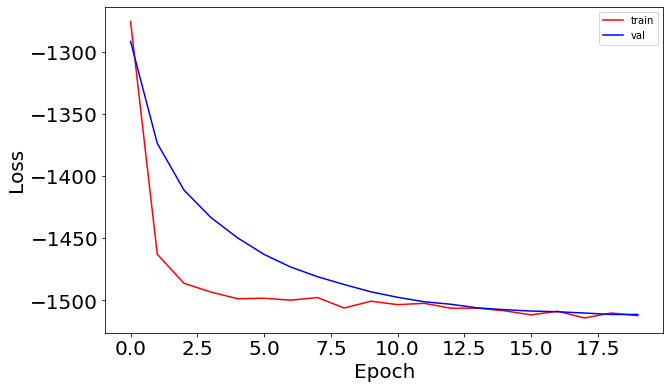

In [76]:
_model, _history = nn.train_model()

nn.plot_loss(_history)

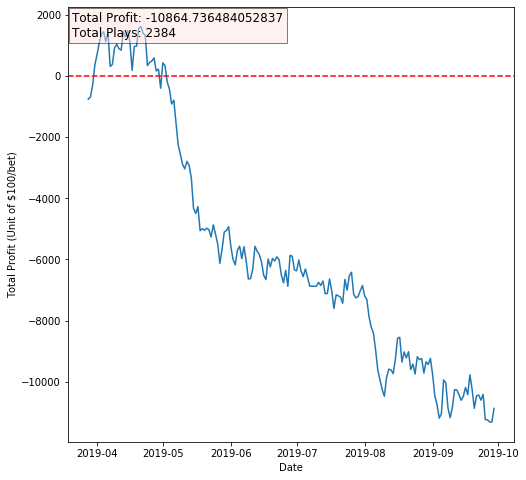

In [86]:
_preds = _model.predict(xtest.values)

bc = BankrollCalculator(_preds, elo_test_target.home_win.values, elo_test.date, elo_test.home_closing, 
                        elo_test.road_closing)

bc.plot_profit()

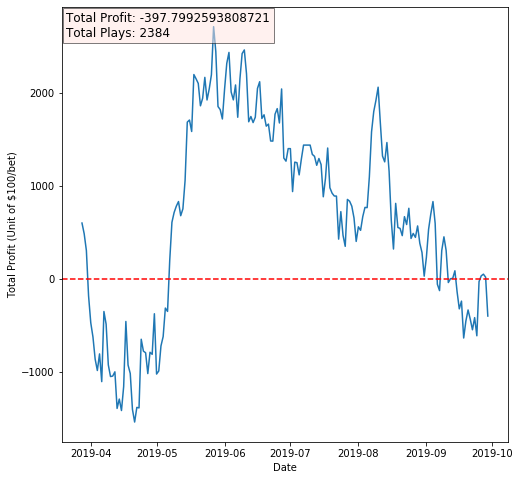

In [87]:
_flip = [0 if i > 0.5 else 1 for i in _preds]

bc = BankrollCalculator(_flip, elo_test_target.home_win.values, elo_test.date, elo_test.home_closing, 
                        elo_test.road_closing)

bc.plot_profit()

# NEW IDEA

In [89]:
df2 = pd.read_csv("./all_features.csv.gz", compression = "gzip")

df2.head()

,date,is_doubleheader,is_tripleheader,home_OBPS,home_AVG_RUNS,home_AVG_H,home_BULLPEN_ERA,home_BULLPEN_WHIP,home_BULLPEN_AVG_INNINGS,home_total_OBPS,home_total_AVG_RUNS,home_total_AVG_H,home_total_BULLPEN_ERA,home_total_BULLPEN_WHIP,home_total_BULLPEN_AVG_INNINGS,road_OBPS,road_AVG_RUNS,road_AVG_H,road_BULLPEN_ERA,road_BULLPEN_WHIP,road_BULLPEN_AVG_INNINGS,road_total_OBPS,road_total_AVG_RUNS,road_total_AVG_H,road_total_BULLPEN_ERA,road_total_BULLPEN_WHIP,road_total_BULLPEN_AVG_INNINGS,home_starter,home_career_ERA,home_career_WHIP,home_career_AVGIP,home_career_ERA_AH,home_career_WHIP_AH,home_career_AVGIP_AH,home_season_ERA,home_season_WHIP,home_season_AVGIP,home_season_ERA_AH,home_season_WHIP_AH,home_season_AVGIP_AH,road_starter,road_career_ERA,road_career_WHIP,road_career_AVGIP,road_career_ERA_OR,road_career_WHIP_OR,road_career_AVGIP_OR,road_season_ERA,road_season_WHIP,road_season_AVGIP,road_season_ERA_OR,road_season_WHIP_OR,road_season_AVGIP_OR,team1,team2,home_loss,elo1_pre,elo2_pre,elo_prob1,elo_prob2,rating1_pre,rating2_pre,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,score1,score2,pitching_park_factor,batting_park_factor,TMAX,PRCP,SNOW,SNWD,attendance,current_streak_hm_tm,current_streak_hm_at_hm,home_record_hm,run_differential_hm,avg_margin_hm,distance_traveled,current_streak_rd_tm,current_streak_rd_tm_on_rd,rd_record_rd,run_differential_rd,avg_margin_rd,roof_closed,is_retractable,is_wildcard,is_divisional,is_championship,is_world_series,is_daygame,is_march,is_april,is_may,is_june,is_july,is_august,is_september,is_october,is_november
0,1918-04-15,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,ruthb101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,myere101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BOS,OAK,0,1532.718,1454.138,0.643479,0.356521,1532.879,1450.425,58.694,42.578,0.123919,7.593298,0.641039,0.358961,7.0,1.0,97.0,99.0,200.0,0.0,0.0,0.0,7000.0,0.0,0.0,0.0,0.0,0.0,429.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1918-04-15,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,johnw102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mogrg101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MIN,NYY,1,1506.347,1489.014,0.559204,0.440796,1505.980,1490.018,59.276,47.036,5.280727,12.779345,0.546438,0.453562,3.0,6.0,98.0,98.0,222.0,0.0,0.0,0.0,2461.0,0.0,0.0,0.0,0.0,0.0,338.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1918-04-16,0,0,0.696944,7.0,9.0,0.0,0.0,0.0,0.696944,7.0,9.0,0.0,0.0,0.0,0.315152,1.0,4.0,0.0,1.5,2.0,0.315152,1.0,4.0,0.0,1.5,2.0,maysc101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,perrs101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BOS,OAK,0,1534.862,1451.995,0.649121,0.350879,1534.475,1448.829,57.569,46.170,0.123919,7.593298,0.642947,0.357053,1.0,0.0,97.0,99.0,172.0,0.0,0.0,0.0,2145.0,1.0,1.0,1.0,6.0,6.0,429.0,-1.0,-1.0,-1.0,-6.0,-6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1918-04-16,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,mayee101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ragap101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PHI,ATL,0,1531.086,1511.721,0.562085,0.437915,1532.047,1510.253,47.964,50.186,5.197198,8.713313,0.566415,0.433585,5.0,2.0,108.0,107.0,161.0,0.0,0.0,0.0,10000.0,0.0,0.0,0.0,0.0,0.0,428.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1918-04-16,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,cicoe101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,lowdg101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CHW,BAL,1,1557.404,1464.028,0.662772,0.337228,1557.576,1465.255,59.669,46.649,-3.174204,13

In [93]:
df2.date = pd.to_datetime(df2.date, format = "%Y-%m-%d")

df2["season"] = pd.DatetimeIndex(df2.date).year

df2 = df2[df2.season >= 2010].reset_index(drop = True)

In [95]:
df2 = df2[["date", "is_doubleheader", "team1", "team2", "current_streak_hm_tm", 
         "current_streak_hm_at_hm", "home_record_hm", "run_differential_hm", "avg_margin_hm",
         "current_streak_rd_tm", "current_streak_rd_tm_on_rd", "rd_record_rd", "run_differential_rd",
         "avg_margin_rd"]].rename(columns = {"team1" : "home_team", "team2" : "road_team"})

df2.head()

,date,is_doubleheader,home_team,road_team,current_streak_hm_tm,current_streak_hm_at_hm,home_record_hm,run_differential_hm,avg_margin_hm,current_streak_rd_tm,current_streak_rd_tm_on_rd,rd_record_rd,run_differential_rd,avg_margin_rd
0,2010-04-04,0,BOS,NYY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-04-05,0,CIN,STL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-04-05,0,CHW,CLE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-04-05,0,PIT,LAD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010-04-05,0,OAK,SEA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
merge_cols = ["date", "is_doubleheader", "home_team", "road_team"]

df.date = pd.to_datetime(df.date, format = "%Y-%m-%d")

df = df.merge(df2, how = "left", left_on = merge_cols, right_on = merge_cols)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23939 entries, 0 to 23938
Columns: 111 entries, date to avg_margin_rd
dtypes: datetime64[ns](1), float32(2), float64(94), int64(8), object(6)
memory usage: 20.3+ MB


In [155]:
training = df[df.season < 2019]

test = df[df.season == 2019].reset_index(drop = True)

In [156]:
drop_cols = ["date", "home_close_TJ", "home_close_ou", "home_closing", "home_open_TJ", "home_open_ou", 
            "home_opening", "home_runline", "home_runline_juice", "is_doubleheader", 
            "road_close_TJ", "road_close_ou", "road_closing", "road_open_TJ", "road_open_ou", 
            "road_opening", "road_runline", "road_runline_juice", "is_tripleheader", "season", "home_team", 
            "road_team", "home_starter", "road_starter", "home_payout", "road_payout", "score1", "score2",
            "home_win", "home_favorite", "line_movement", "money_scalar"]

train_target = training.home_payout

test_target = test.home_payout

xtrain, xtest = training.drop(columns = drop_cols), test.drop(columns = drop_cols)

In [159]:
keep_cols = ["home_wRC", "home_relief_wRC", "home_starter_career_wRC", "home_starter_season_wRC",
            "road_wRC", "road_relief_wRC", "road_starter_career_wRC", "road_starter_season_wRC",
            "rating1_pre", "rating2_pre", "current_streak_hm_tm", "current_streak_hm_at_hm", 
            "home_record_hm", "run_differential_hm", "avg_margin_hm", "current_streak_rd_tm", 
            "current_streak_rd_tm_on_rd", "rd_record_rd", "run_differential_rd", "avg_margin_rd"]

xtrain = xtrain[keep_cols]

xtest = xtest[keep_cols]

In [161]:
from sklearn.linear_model import Lasso, SGDRegressor, LinearRegression
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score

In [162]:
xtrain, ss = PrepTools(xtrain, train_target).scale_features(save_scaler = True)

xtest = PrepTools(xtest, test_target).scale_features(load_scaler = ss)

In [163]:
l = LinearRegression()

l.fit(xtrain, train_target)

ypreds = l.predict(xtest)

In [165]:
bets = []

for i in range(len(ypreds)):
    
    if ypreds[i] < test_target[i]:
        
        bets.append(1)
        
    else:
        
        bets.append(0)

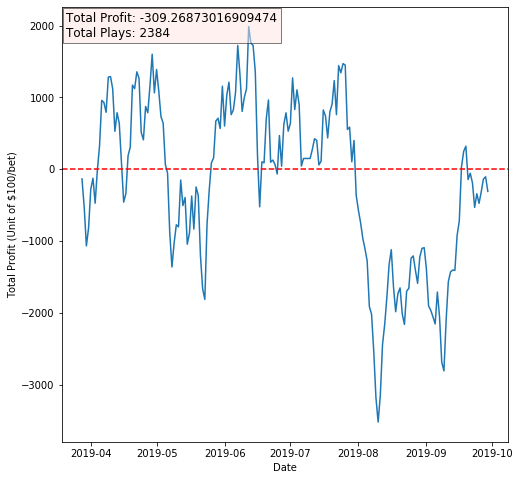

In [166]:
hc, rc, dates  = test.home_closing, test.road_closing, test.date

bc = BankrollCalculator(bets, test.home_win.values, dates, hc, 
                        rc)

bc.plot_profit()

In [167]:
SGDRegressor().get_params()

{'alpha': 0.0001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_loss',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [168]:
SGD_params = {
    
    "loss" : "squared_loss",
    
    "penalty" : "l1",
    
    "fit_intercept" : False,
    
    "alpha" : 0.0001, 
    
    "learning_rate" : "invscaling",
    
    "eta0" : 0.1
    
}

sgd = SGDRegressor().set_params(**SGD_params)

sgd.fit(xtrain, train_target)

sgd_preds = sgd.predict(xtest)

In [172]:
bets_scheme1 = []

bets_scheme2 = []

for i in sgd_preds:
    
    if i < 0:
        
        bets_scheme1.append(1)
        
        bets_scheme2.append(0)
        
    else:
        
        bets_scheme1.append(0)
        
        bets_scheme2.append(1)

Graphic written to file ./adv_metrics/adv_metric_plots/SGDR_line_pred


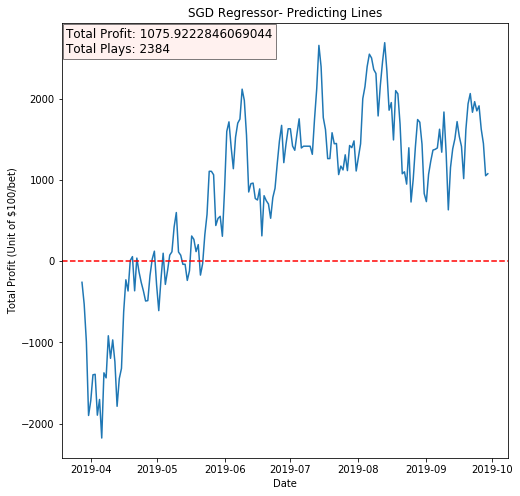

In [177]:
bc = BankrollCalculator(bets_scheme1, test.home_win.values, dates, hc, 
                        rc, fig_title = "SGD Regressor- Predicting Lines",
                       save_fig = True, img_dest = "./adv_metrics/adv_metric_plots/SGDR_line_pred")

bc.plot_profit()

In [180]:
bets_scheme3 = []

index = []

for i in range(len(sgd_preds)):
    
    if sgd_preds[i] < -0.5:
        
        bets_scheme3.append(1)
        
        index.append(i)
        
    elif sgd_preds[i] > 0.5:
        
        bets_scheme3.append(0)
        
        index.append(i)
        
    else:
        
        continue

Graphic written to file ./adv_metrics/adv_metric_plots/SGDR_line_pred2


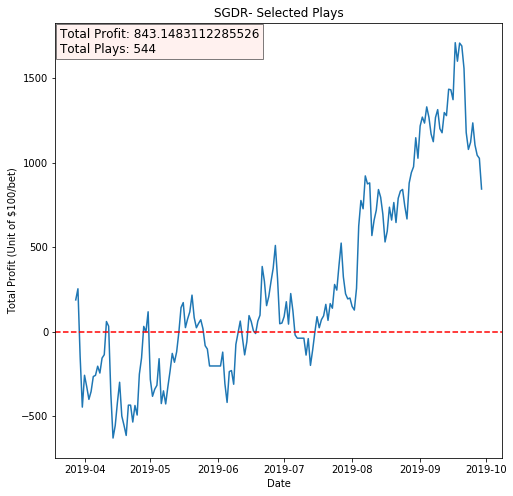

In [188]:
bc = BankrollCalculator(bets_scheme3, test.home_win[index].reset_index(drop = True),
                        dates[index].reset_index(drop = True), hc[index].reset_index(drop = True), 
                        rc[index].reset_index(drop = True), fig_title = "SGDR- Selected Plays",
                       save_fig = True, img_dest = "./adv_metrics/adv_metric_plots/SGDR_line_pred2")

bc.plot_profit()

In [203]:
coefs = list(abs(sgd.coef_))

features = list(xtrain.columns)

coef_df = pd.DataFrame({"feature" : features, "coefficient" : coefs})

In [204]:
coef_df.sort_values(by = ["coefficient"], ascending = False)

,feature,coefficient
8,rating1_pre,0.227829
9,rating2_pre,0.171413
3,home_starter_season_wRC,0.066127
15,current_streak_rd_tm,0.041278
16,current_streak_rd_tm_on_rd,0.001548
0,home_wRC,0.000000
12,home_record_hm,0.000000
18,run_differential_rd,0.000000
17,rd_record_rd,0.000000
14,avg_margin_hm,0.000000


In [205]:
from sklearn.ensemble import RandomForestRegressor

In [206]:
rfc = RandomForestRegressor(n_estimators = 100)

rfc.fit(xtrain, train_target)

rfc_preds = rfc.predict(xtest)

In [209]:
importances = list(rfc.feature_importances_)

features = list(xtrain.columns)

coef_df = pd.DataFrame({"feature" : features, "importance" : importances})

coef_df.sort_values(by = ["importance"], ascending = False)

,feature,importance
8,rating1_pre,0.311139
9,rating2_pre,0.310113
6,road_starter_career_wRC,0.049210
2,home_starter_career_wRC,0.045540
7,road_starter_season_wRC,0.034367
3,home_starter_season_wRC,0.027118
4,road_wRC,0.026443
0,home_wRC,0.025994
1,home_relief_wRC,0.024445
5,road_relief_wRC,0.023369


In [211]:
rfc_scheme = []

for i in range(len(rfc_preds)):
    
    if rfc_preds[i] < test_target[i]:
        
        rfc_scheme.append(1)
        
    else:
        
        rfc_scheme.append(0)

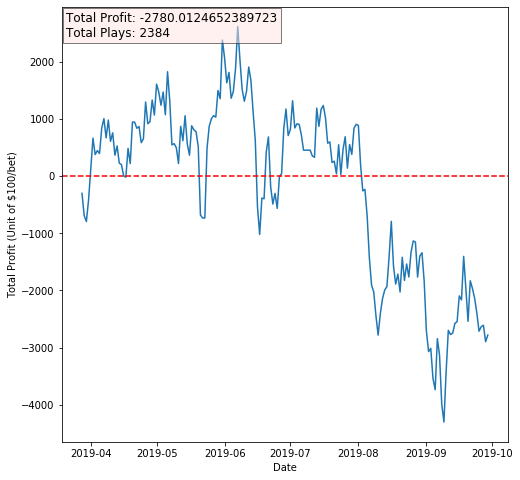

In [212]:
bc = BankrollCalculator(rfc_scheme, test.home_win.values, dates, hc, 
                        rc)

bc.plot_profit()

In [213]:
from xgboost import XGBRegressor

In [215]:
XGBRegressor().get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [222]:
XGB = XGBRegressor(objective = "reg:squarederror")

XGB.fit(xtrain.values, train_target.values)

XGB_preds = XGB.predict(xtest.values)

In [224]:
XGB_scheme = []

for i in range(len(XGB_preds)):
    
    if XGB_preds[i] < test_target[i]:
        
        XGB_scheme.append(1)
        
    else:
        
        XGB_scheme.append(0)

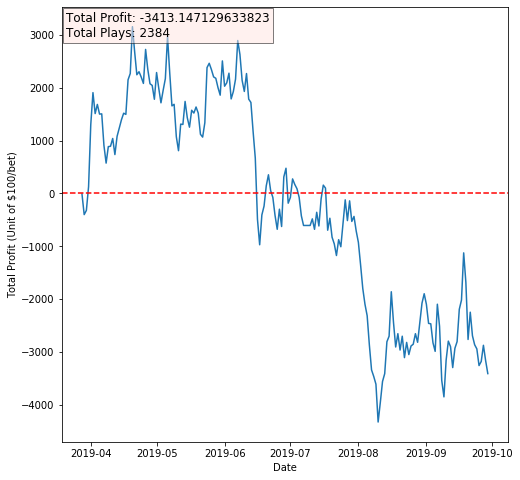

In [225]:
bc = BankrollCalculator(XGB_scheme, test.home_win.values, dates, hc, 
                        rc)

bc.plot_profit()

In [464]:
net_params = ["home_wRC", "home_relief_wRC", "home_starter_career_wRC", "home_starter_season_wRC",
             "road_wRC", "road_relief_wRC", "road_starter_career_wRC", "road_starter_season_wRC",
             "home_payout", "road_payout", "rating1_pre", "rating2_pre", "pitcher1_rgs", "pitcher2_rgs",
             "pitcher1_adj", "pitcher2_adj", "home_win", "line_movement", "money_scalar", "current_streak_hm_tm",
             "current_streak_hm_at_hm", "home_record_hm", "run_differential_hm", "avg_margin_hm", 
             "current_streak_rd_tm", "current_streak_rd_tm_on_rd", "rd_record_rd", "run_differential_rd",
             "avg_margin_rd"]

SGDR_params = ["rating1_pre", "rating2_pre", "pitcher1_rgs", "pitcher2_rgs", "pitcher1_adj", "pitcher2_adj", 
              "home_win", "home_favorite", "line_movement", "money_scalar", "home_payout", "road_payout"]

In [327]:
sgdr_train, sgdr_test = training[SGDR_params], test[SGDR_params]

In [328]:
sgdr_train.head()

,rating1_pre,rating2_pre,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,home_win,home_favorite,line_movement,money_scalar,home_payout,road_payout
0,1536.601,1562.673,57.031,61.828,27.349300,46.7039,1,1,1,-3.0,1.854701,2.070000
1,1460.662,1537.875,49.834,62.166,8.394200,49.4957,0,0,0,0.0,2.750000,1.500000
2,1513.910,1500.945,56.701,60.524,7.593298,46.4172,0,0,-1,27.0,2.370000,1.657895
3,1543.114,1520.771,54.034,55.637,16.337200,26.8276,1,1,-1,7.0,1.781250,2.130000
4,1478.280,1500.407,63.333,58.357,64.723700,40.3119,0,1,1,-7.0,1.819672,2.120000


In [329]:
sgdr_train_target, sgdr_test_target = sgdr_train["home_payout"], sgdr_test["home_payout"]

sgdr_train = sgdr_train.drop(columns = ["home_win", "home_favorite", "line_movement", "money_scalar",
                                       "home_payout", "road_payout"])

sgdr_test = sgdr_test.drop(columns = ["home_win", "home_favorite", "line_movement", "money_scalar",
                                     "home_payout", "road_payout"])

In [332]:
xtrain, ss = PrepTools(sgdr_train, sgdr_train_target).scale_features(save_scaler = True)

xtest = PrepTools(sgdr_test, sgdr_test_target).scale_features(load_scaler = ss)

In [373]:
XGB_params = {
    
    "objective" : "reg:squarederror"
    
}

xgb = XGBRegressor().set_params(**XGB_params)

xgb.fit(xtrain.values, sgdr_train_target.values)

xgb_preds = xgb.predict(xtest.values)

In [411]:
xgb_ = pd.Series(xgb_preds).rename("XGB_LINE")

true = test.home_payout

true_ = test.road_payout

lines_df = pd.concat([xgb_, true, true_, test.home_win], axis = 1)

In [452]:
plays = []

for k in range(len(lines_df)):
    
    if lines_df.iloc[k]["home_payout"] - lines_df.iloc[k]["XGB_LINE"] > 0.25:
        
        plays.append(1)
        
    elif lines_df.iloc[k]["XGB_LINE"] - lines_df.iloc[k]["home_payout"] > 0.25:
        
        plays.append(-1)
        
    else:
        
        plays.append(0)

In [453]:
lines_df = lines_df.drop(columns = ["plays"])

In [454]:
plays_ = pd.Series(plays).rename("plays")

lines_df = pd.concat([lines_df, plays_], axis = 1)

In [455]:
road_wins = (lines_df[(lines_df.home_win == 0) & (lines_df.plays == -1)].road_payout.sum() -\
            len(lines_df[(lines_df.home_win == 0) & (lines_df.plays == -1)])) * 100
road_losses = len(lines_df[(lines_df.home_win == 1) & (lines_df.plays == -1)]) * 100 

In [456]:
home_wins = (lines_df[(lines_df.home_win == 1) & (lines_df.plays == 1)].home_payout.sum() -\
            len(lines_df[(lines_df.home_win ==1) & (lines_df.plays == 1)])) * 100

In [457]:
home_lossess = len(lines_df[(lines_df.home_win == 0) & (lines_df.plays == 1)]) * 100

In [458]:
road_wins - road_losses

15.302035800140402

In [459]:
home_wins - home_lossess

-682.1641471980474

In [402]:
lines_df.to_csv("./XGB_winning_combo.csv.gz", index = False, compression = "gzip")

In [381]:
plays = lines_df[(lines_df.XGB_LINE < 2.) & (lines_df.home_closing > 0)]

In [382]:
wins = plays[(plays.home_win == 1)]

In [386]:
wins.home_closing.sum() - 8100

787.0

In [371]:
bets_scheme1 = []

bets_scheme2 = []

for i in sgd_preds:
    
    if i < 0:
        
        bets_scheme1.append(1)
        
        bets_scheme2.append(0)
        
    else:
        
        bets_scheme1.append(0)
        
        bets_scheme2.append(1)

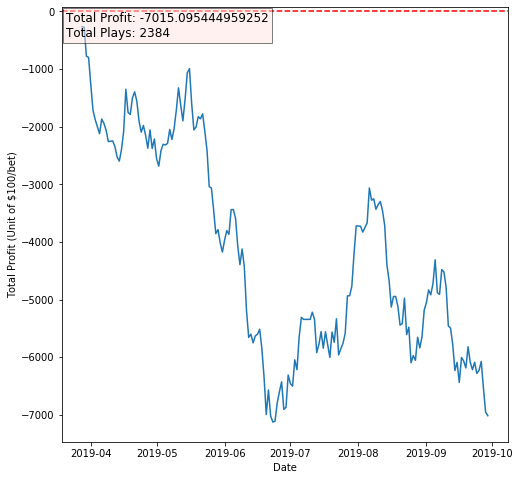

In [372]:
bc = BankrollCalculator(bets_scheme1, test.home_win.values, dates, hc, 
                        rc)

bc.plot_profit()

In [467]:
net_train = training[net_params].reset_index(drop = True)

net_test = test[net_params].reset_index(drop = True)

In [468]:
net_train.home_payout = net_train.home_payout -1 

net_train.road_payout = net_train.road_payout - 1

net_test.home_payout = net_test.home_payout - 1

net_test.road_payout = net_test.road_payout - 1

In [469]:
net_train_target = net_train[["home_win", "home_payout", "road_payout"]].values

net_test_target = net_test[["home_win", "home_payout", "road_payout"]].values

train_AB = net_train["line_movement"]

test_AB = net_test["line_movement"]

net_train = net_train.drop(columns = ["home_win", "line_movement"])

net_test = net_test.drop(columns = ["home_win", "line_movement"])

scNet_train, ss = PrepTools(net_train, net_train_target).scale_features(save_scaler = True)

scNet_test = PrepTools(net_test, net_test_target).scale_features(load_scaler = ss)

scNet_train = pd.concat([scNet_train, train_AB], axis = 1)

scNet_test = pd.concat([scNet_test, test_AB], axis = 1)

In [470]:
scNet_train.shape, net_train_target.shape, scNet_test.shape, net_test_target.shape

((21555, 28), (21555, 3), (2384, 28), (2384, 3))

In [478]:
nn_params = {
    
    "training" : scNet_train.values,
    
    "train_target" : net_train_target,
    
    "validation" : scNet_test.values,
    
    "validation_target" : net_test_target,
    
    "objective" : "binary",
    
    "n_classes" : 1,
    
    "n_hidden": 5,
    
    "external_validation" : True,
    
    "base_neurons" : 50,
    
    "shape" : "funnel",
    
    "funnel_param" : 0.5,
    
    "normalize_batches" : True,
    
    "early_stopping" : True,
    
    "early_stopping_params" : {
        
        "monitor" : "val_loss",
        
        "patience" : 25,
        
        "mode" : "min",
        
        "restore_best_weights" : True
    },
    
    "compile_params" : {
        
        "optimizer" : "adam",
        
        "loss" : gambling_loss_ReLu
    },
    
    "fit_params" : {
        
        "epochs" : 500,
        
        "batch_size" :2056,
        
        "verbose" : 1
    }
}

nn = NeuralNetConstructor(**nn_params)

Train on 21555 samples, validate on 2384 samples
Epoch 1/500
21555/21555 [==============================] - 1s 61us/sample - loss: -83.4520 - val_loss: -114.9682
Epoch 2/500
21555/21555 [==============================] - 0s 4us/sample - loss: -94.2305 - val_loss: -117.8181
Epoch 3/500
21555/21555 [==============================] - 0s 4us/sample - loss: -104.1681 - val_loss: -126.9041
Epoch 4/500
21555/21555 [==============================] - 0s 4us/sample - loss: -111.9258 - val_loss: -139.7474
Epoch 5/500
21555/21555 [==============================] - 0s 4us/sample - loss: -117.2283 - val_loss: -150.2895
Epoch 6/500
21555/21555 [==============================] - 0s 4us/sample - loss: -119.9519 - val_loss: -158.3316
Epoch 7/500
21555/21555 [==============================] - 0s 4us/sample - loss: -121.9869 - val_loss: -164.6158
Epoch 8/500
21555/21555 [==============================] - 0s 4us/sample - loss: -124.4609 - val_loss: -170.7204
Epoch 9/500
21555/21555 [=======================

21555/21555 [==============================] - 0s 4us/sample - loss: -146.6677 - val_loss: -212.5493
Epoch 144/500
21555/21555 [==============================] - 0s 4us/sample - loss: -146.7860 - val_loss: -212.6521
Epoch 145/500
21555/21555 [==============================] - 0s 4us/sample - loss: -146.4679 - val_loss: -212.7569
Epoch 146/500
21555/21555 [==============================] - 0s 4us/sample - loss: -146.7893 - val_loss: -212.8609
Epoch 147/500
21555/21555 [==============================] - 0s 4us/sample - loss: -147.0584 - val_loss: -212.9641
Epoch 148/500
21555/21555 [==============================] - 0s 4us/sample - loss: -147.1724 - val_loss: -213.0637
Epoch 149/500
21555/21555 [==============================] - 0s 4us/sample - loss: -147.3649 - val_loss: -213.1646
Epoch 150/500
21555/21555 [==============================] - 0s 4us/sample - loss: -147.3190 - val_loss: -213.2657
Epoch 151/500
21555/21555 [==============================] - 0s 4us/sample - loss: -147.0789 -

21555/21555 [==============================] - 0s 4us/sample - loss: -150.9813 - val_loss: -221.6093
Epoch 286/500
21555/21555 [==============================] - 0s 4us/sample - loss: -150.9758 - val_loss: -221.6446
Epoch 287/500
21555/21555 [==============================] - 0s 3us/sample - loss: -150.3315 - val_loss: -221.6798
Epoch 288/500
21555/21555 [==============================] - 0s 3us/sample - loss: -151.5132 - val_loss: -221.7148
Epoch 289/500
21555/21555 [==============================] - 0s 3us/sample - loss: -151.6231 - val_loss: -221.7494
Epoch 290/500
21555/21555 [==============================] - 0s 3us/sample - loss: -151.0807 - val_loss: -221.7847
Epoch 291/500
21555/21555 [==============================] - 0s 3us/sample - loss: -150.8455 - val_loss: -221.8187
Epoch 292/500
21555/21555 [==============================] - 0s 3us/sample - loss: -150.9387 - val_loss: -221.8526
Epoch 293/500
21555/21555 [==============================] - 0s 4us/sample - loss: -150.2480 -

21555/21555 [==============================] - 0s 4us/sample - loss: -151.9280 - val_loss: -224.8608
Epoch 428/500
21555/21555 [==============================] - 0s 4us/sample - loss: -152.8848 - val_loss: -224.8751
Epoch 429/500
21555/21555 [==============================] - 0s 4us/sample - loss: -152.4757 - val_loss: -224.8890
Epoch 430/500
21555/21555 [==============================] - 0s 4us/sample - loss: -152.3640 - val_loss: -224.9029
Epoch 431/500
21555/21555 [==============================] - 0s 4us/sample - loss: -151.8484 - val_loss: -224.9166
Epoch 432/500
21555/21555 [==============================] - 0s 4us/sample - loss: -152.8397 - val_loss: -224.9305
Epoch 433/500
21555/21555 [==============================] - 0s 4us/sample - loss: -152.3371 - val_loss: -224.9442
Epoch 434/500
21555/21555 [==============================] - 0s 4us/sample - loss: -153.4268 - val_loss: -224.9578
Epoch 435/500
21555/21555 [==============================] - 0s 4us/sample - loss: -152.2968 -

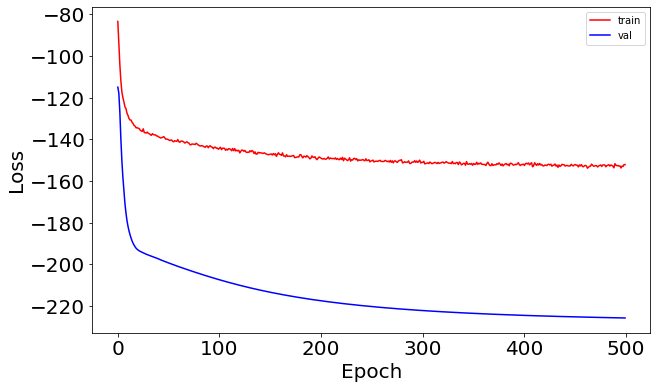

In [479]:
_model, _history = nn.train_model()

nn.plot_loss(_history)

In [480]:
nn_preds = _model.predict(scNet_test)

In [481]:
nn_preds

array([[9.7043419e-01],
       [9.7043419e-01],
       [9.7043419e-01],
       ...,
       [1.7552369e-05],
       [9.7043419e-01],
       [6.5552327e-04]], dtype=float32)

In [313]:
schema = []
indices = []

for i in range(len(nn_preds)):
    
    if nn_preds[i] > 0.8:
        
        schema.append(0)
        
        indices.append(i)
        
    elif nn_preds[i] < 0.2:
        
        schema.append(1)
        
        indices.append(i)
        
    else:
        
        continue

In [314]:
len(indices)

2165

In [483]:
flip = [1 if i < 0.5 else 0 for i in nn_preds]

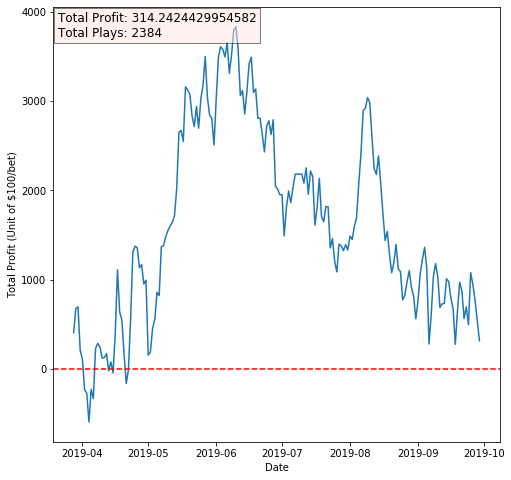

In [485]:

bc = BankrollCalculator(flip, test.home_win.values, test.date, test.home_closing, 
                        test.road_closing)

bc.plot_profit()